## 0- Prerequisite, Packages Imports and Data Imports

This section ensures all required Python libraries are imported and that the dataset is successfully loaded into memory. The imported packages provide functionalities for data handling, visualization, modeling, and explainability.<br>
The data import cell reads the event log and confirms its structure through dimensionality checks and sampling a few rows. This step ensures that the dataset is accessible, correctly formatted, and ready for subsequent analysis.

In [2]:
!pip install pm4py


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from typing import List

from pm4py.objects.log.util import dataframe_utils
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.visualization.heuristics_net import visualizer as hn_visualizer

from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import TruncatedSVD

In [4]:
df = pd.read_csv('/Users/victor/code/escp/thesis/Master-Thesis---Process-Mining-with-NLP/bpi2018_events.csv')

## 1- Data Exploration

### 1.1 – Basic Overview: Dimensions, Duplicates, Nulls

An initial overview of the dataset is performed to understand its shape and completeness.  
The following diagnostics are calculated:
- The number of rows and columns, representing events and attributes.  
- Duplicate event detection to ensure data uniqueness.  
- Missing-value counts to assess data quality and determine which columns may require cleaning or removal.  

This stage provides a quantitative baseline of data integrity before feature engineering.

In [5]:
# Dimensions
print("Shape:", df.shape)

Shape: (2057551, 75)


In [6]:
# Missing values
null_counts = df.isnull().sum().sort_values(ascending=False)
print("Null counts:\n", null_counts[null_counts > 0])

Null counts:
 case:amount_applied3    2055301
case:payment_actual3    2055301
case:penalty_amount3    2055301
case:amount_applied2    2035001
case:payment_actual2    2035001
case:penalty_amount2    2035001
case:amount_applied1    1797235
case:penalty_amount1    1797235
case:payment_actual1    1797235
eventid                  102302
note                       3920
dtype: int64


In [7]:
# Duplicates
print("Duplicates:", df.duplicated().sum())

Duplicates: 0


### 1.2 – Drop Irrelevant Columns

Columns that do not contribute to process analysis or modeling are removed.  
These include unique identifiers, system-generated metadata, and fields with excessive missing values.  

This step reduces noise and improves computational efficiency while retaining all columns that convey process-related or semantic meaning.

In [8]:
# Drop if too many NaNs (> 98%)
too_null = df.columns[df.isnull().mean() > 0.98].tolist()
df_cleaned = df.drop(columns=too_null)

In [9]:
df_cleaned.shape

(2057551, 69)

### 1.3 – Understand Target: “success”

The `success` field is analyzed to confirm its definition and consistency across events within each case.  
Cases are grouped by their identifiers to check whether the success label remains uniform or varies across activities.  

This exploration helps define a meaningful case-level target later in the pipeline.  
The results of this analysis guide whether success should be defined as the last event’s status, or as all events being successful.

In [10]:
# How many unique cases?
print("Unique cases:", df_cleaned['case:concept:name'].nunique())

Unique cases: 36000


In [11]:
# How is success distributed?
print(df_cleaned['success'].value_counts())

True     2036893
False      20658
Name: success, dtype: int64


In [12]:
# Group by case to check consistency
success_per_case = df_cleaned.groupby('case:concept:name')['success'].nunique()
print("Cases with inconsistent success labels:", (success_per_case > 1).sum())

Cases with inconsistent success labels: 11137


In [13]:
df_sorted = df_cleaned.sort_values('time:timestamp')
last_success = df_sorted.groupby('case:concept:name').tail(1)[['case:concept:name', 'success']]

In [14]:
last_success['success'].value_counts()

True     35936
False       64
Name: success, dtype: int64

In [15]:
last_success[last_success['success']==False]

case:concept:name  success
489082   2caf02a705ed8843    False
1551187  8ccf83777d480e51    False
1377941  d5ab081c02f82462    False
1014695  856c4026b25d5014    False
36453    fd61f08062497980    False
...                   ...      ...
15764    e467a942a2e909c1    False
818924   c6fe1399fe86dc9c    False
383535   648735cbbc87fd42    False
1582729  ee068573cb4ccf56    False
2032462  630ec78ab455e3f9    False

[64 rows x 2 columns]

In [16]:
df_cleaned[df_cleaned['case:concept:name']=='2caf02a705ed8843']

success                   org:resource  \
488976     True                          0;n/a   
488977     True                          0;n/a   
488978     True                          0;n/a   
488979     True                          0;n/a   
488980     True  Document processing automaton   
...         ...                            ...   
489078     True                           DP-Z   
489079    False                         354865   
489080    False                         354865   
489081     True                         5a21a5   
489082    False                         354865   

                                  docid_uuid                  doctype  \
488976  47AC776F-6F5A-487B-805C-7371D54CD91D      Payment application   
488977  07AF4F51-F8CA-434F-B3D8-70CF6BBECEAE  Entitlement application   
488978  47AC776F-6F5A-487B-805C-7371D54CD91D      Payment application   
488979  07AF4F51-F8CA-434F-B3D8-70CF6BBECEAE  Entitlement application   
488980  7B397285-D848-4438-BEB0-7EF3D7669965          Parcel document   
...                                      ...                      ...   
489078  47AC776F-6F5A-487B-805C-7371D54CD91D      Payment application   
489079  47AC776F-6F5A-487B-805C-7371D54CD91D      Payment application   
489080  47AC776F-6F5A-487B-805C-7371D54CD91D      Payment application   
489081  B8C22B12-4AEA-492B-9BB8-5A8DC565295F      Reference alignment   
489082  47AC776F-6F5A-487B-805C-7371D54CD91D      Payment application   

         subprocess              docid         activity  \
488976  Application -18008611495744398      mail income   
488977         Main -18008615298805539       mail valid   
488978  Application -18008611495744398       mail valid   
488979         Main -18008615298805539       mail valid   
488980         Main -18008662111764143       initialize   
...             ...                ...              ...   
489078    Objection -18008611495744398   finish payment   
489079    Objection -18008611495744398  insert document   
489080    Objection -18008611495744398  remove document   
489081         Main -54037444591229127             save   
489082    Objection -18008611495744398  remove document   

                              note       eventid  \
488976                        none           NaN   
488977                        none           NaN   
488978                        none           NaN   
488979                        none           NaN   
488980                        none -1.800866e+16   
...                            ...           ...   
489078    automatic during payment -1.800851e+16   
489079  notification for applicant -9.006611e+16   
489080  notification for applicant -9.006611e+16   
489081                        none -9.006610e+16   
489082  notification for applicant -1.080805e+17   

                                 identity:id  ... case:year case:penalty_JLP5  \
488976  6EA5976D-0131-4084-A7AF-A84A40D316F8  ...      2015             False   
488977  6BD90534-98E0-463B-A96C-F48E3E41A4DE  ...      2015             False   
488978  1C64B4DA-F83E-4CEF-8F89-2EC21EC8672C  ...      2015             False   
488979  B3434D49-82AA-4A95-BCB3-A8CDF70544E8  ...      2015             False   
488980  BBEB5D70-598E-4C49-BF8B-C155ADF1F0E5  ...      2015             False   
...                                      ...  ...       ...               ...   
489078  E07AD673-34DD-4462-B2DE-99DB01474E25  ...      2015             False   
489079  D730A6C5-8124-4F46-A86C-18B4AC29C2C8  ...      2015             False   
489080  1016EB91-5176-49C1-9C1E-A4C439347D6A  ...      2015             False   
489081  A74A9DF6-F438-495C-9DEB-95EAF97AC246  ...      2015             False   
489082  77156ACE-0DD9-4BC3-B4B1-7B9B05124BCF  ...      2015             False   

       case:penalty_JLP2  case:penalty_JLP3  case:number_parcels  \
488976             False              False                   31   
488977             False              False                   31   
488978             

In [17]:
df_cleaned['activity'].value_counts()

calculate                     380918
finish editing                355622
begin editing                 303842
save                          248786
initialize                    172615
decide                         79418
begin payment                  71426
performed                      68259
mail valid                     66303
insert document                65422
finish payment                 38149
mail income                    35999
abort payment                  33277
create                         29794
revoke decision                21848
check                          13588
finish pre-check               11691
finish preparations            10878
begin preparations             10876
prepare external                8162
abort external                  6318
remove document                 5157
plan                            4389
clear                           2367
begin admissibility check       1888
check admissibility             1819
prepare offline                 1581
p

### 1.4 – Identify Useful Text Fields

All potentially relevant text columns are reviewed to determine their usefulness for Natural Language Processing (NLP) later in the workflow.  
Columns such as `note`, `activity`, `subprocess`, and `doctype` are prioritized if they contain meaningful textual information rather than system codes or placeholders.  

This selection ensures that only semantically rich attributes contribute to the textual representation of each case.

In [18]:
text_cols = ['note', 'activity', 'subprocess', 'doctype']
for col in text_cols:
    print(f"\nTop values in {col}:")
    print(df_cleaned[col].value_counts().head(10))


Top values in note:
none                                       1038625
automatic                                   787956
automatic during payment                    142852
notification for applicant                   35030
created                                      29794
change by department                         12115
manual note                                   4067
objection                                     1564
attachment                                     217
Gesamtparzelle 35 berechnet und geprüft        179
Name: note, dtype: int64

Top values in activity:
calculate          380918
finish editing     355622
begin editing      303842
save               248786
initialize         172615
decide              79418
begin payment       71426
performed           68259
mail valid          66303
insert document     65422
Name: activity, dtype: int64

Top values in subprocess:
Application    785333
Main           764621
Declared       150698
Reported       126604
On-Site        

In [19]:
df_cleaned['concept:name']

0             mail income
1              mail valid
2              mail valid
3              mail valid
4              initialize
                ...      
2057546    finish editing
2057547     begin editing
2057548         calculate
2057549    finish editing
2057550            decide
Name: concept:name, Length: 2057551, dtype: object

## 2 – Data Cleaning & Feature Exploration

### 2.1 — Fix and Format Timestamps

The `time:timestamp` column is converted to a standardized datetime format.  
This conversion ensures correct chronological ordering of events within each case and enables time-based feature creation (for example, duration or inter-event gaps).  

This step guarantees temporal consistency for both process mining and performance analysis.

In [20]:
df_cleaned['time:timestamp'] = pd.to_datetime(df_cleaned['time:timestamp'], errors='coerce')

### 2.2 — Text Cleanup on note

Textual cleaning is applied to the `note` field, which often contains administrative phrases or placeholders such as “none.”  
Transformations include:
- Conversion to lowercase,  
- Removal of placeholder tokens,  
- Stripping of unnecessary spaces.  

This preprocessing step prepares text attributes for later aggregation and vectorization, improving the quality of textual features.

In [21]:
df_cleaned['note_cleaned'] = df_cleaned['note'].astype(str).str.strip().str.lower()

## 3 — Process Visualization and Case Variant Analysis

In this stage, we move from raw cleaning to understanding the process structure and behavior.
The goal is to discover patterns, bottlenecks, and deviations that connect to your thesis theme, showing how structured process attributes and textual elements jointly explain efficiency and success

### 3.1 Case-Level Metrics and Success Consistency

Case-level statistics are calculated, including:
- Number of activities per case,  
- Start and end timestamps,  
- Case duration in hours,  
- Internal consistency of success labels.  

This aggregation converts the event log into a structured case table, enabling comparisons of process length, duration, and success.


In [22]:
CASE_COL = 'case:concept:name'
ACT_COL = 'activity'
TIME_COL = 'time:timestamp'
SUCCESS_COL = 'success'

df_cleaned[TIME_COL] = pd.to_datetime(df_cleaned[TIME_COL], errors='coerce')
df_cleaned = df_cleaned.dropna(subset=[CASE_COL, ACT_COL, TIME_COL]).sort_values([CASE_COL, TIME_COL])
df_cleaned['event_idx'] = df_cleaned.groupby(CASE_COL).cumcount()

case_agg = df_cleaned.groupby(CASE_COL).agg(
    n_events=('activity','size'),
    start_time=(TIME_COL,'min'),
    end_time=(TIME_COL,'max'),
    success_all=(SUCCESS_COL,'all'),
    success_any=(SUCCESS_COL,'any')
).reset_index()
case_agg['duration_hours']=(case_agg['end_time']-case_agg['start_time']).dt.total_seconds()/3600

last_ev=df_cleaned.sort_values([CASE_COL,TIME_COL]).groupby(CASE_COL).tail(1)[[CASE_COL,SUCCESS_COL]]
case_agg=case_agg.merge(last_ev.rename(columns={SUCCESS_COL:'success_last'}),on=CASE_COL,how='left')
case_agg.head()

case:concept:name  n_events                start_time  \
0  0002505cb62792e4        56 2015-04-28 00:00:00+00:00   
1  0002a55a6130cec8        40 2015-04-17 00:00:00+00:00   
2  0004ff62053a60ce        51 2015-05-11 00:00:00+00:00   
3  000612b48d30de74       111 2015-05-06 00:00:00+00:00   
4  0006cc909ce508b0        46 2016-04-28 00:00:00+00:00   

                          end_time  success_all  success_any  duration_hours  \
0 2017-08-03 15:54:21.311000+00:00         True         True    19887.905920   
1 2016-02-18 07:41:46.343000+00:00         True         True     7375.696206   
2        2016-08-19 11:56:47+00:00         True         True    11195.946389   
3 2016-09-14 11:47:48.425000+00:00        False         True    11939.796785   
4        2017-06-15 09:24:55+00:00         True         True     9921.415278   

   success_last  
0          True  
1          True  
2          True  
3          True  
4          True

### 3.2 Identify Best vs Worst Cases

Cases are ranked according to their number of activities and duration.  
The most efficient (fewest activities or shortest duration) and least efficient (most activities or longest duration) cases are extracted.  

These subsets are later used to visualize and contrast process behavior under different performance conditions.

In [23]:
min_len, max_len = case_agg['n_events'].min(), case_agg['n_events'].max()
min_dur, max_dur = case_agg['duration_hours'].min(), case_agg['duration_hours'].max()

cases_min_len = case_agg.loc[case_agg['n_events']==min_len,CASE_COL].tolist()
cases_max_len = case_agg.loc[case_agg['n_events']==max_len,CASE_COL].tolist()
cases_min_dur = case_agg.loc[case_agg['duration_hours']==min_dur,CASE_COL].tolist()
cases_max_dur = case_agg.loc[case_agg['duration_hours']==max_dur,CASE_COL].tolist()

sample_cases = {
    'fewest_activities': cases_min_len[:5],
    'most_activities': cases_max_len[:5],
    'shortest_duration': cases_min_dur[:5],
    'longest_duration': cases_max_dur[:5],
}
sample_cases


{'fewest_activities': ['e464e72a43e59a55'],
 'most_activities': ['93deb55be9aed2be'],
 'shortest_duration': ['0c9042c6323fc971'],
 'longest_duration': ['ed78be965bdecdb8']}

### 3.3 Directly-Follows Graph (DFG) Frequencies

A Directly-Follows Graph is constructed to represent the process control flow.  
Each node corresponds to an activity, and each edge represents a transition between consecutive activities.  

Edge frequencies indicate how often transitions occur, providing insight into dominant paths and process loops.

In [24]:
df_pairs = (
    df[[CASE_COL,TIME_COL,ACT_COL]]
    .sort_values([CASE_COL,TIME_COL])
    .assign(next_act=lambda x: x.groupby(CASE_COL)[ACT_COL].shift(-1))
    .dropna(subset=['next_act'])
)
dfg = (
    df_pairs.groupby([ACT_COL,'next_act'])
    .size().reset_index(name='count')
    .sort_values('count',ascending=False)
)
dfg.head(20)


activity        next_act   count
115       calculate  finish editing  231842
39    begin editing       calculate  197780
546            save            save  128631
306      initialize   begin editing  123869
225  finish editing   begin editing  122102
105       calculate       calculate   82891
237  finish editing          decide   75315
46    begin editing  finish editing   56202
243  finish editing      initialize   52492
319      initialize       performed   35996
198          decide   begin payment   35363
102       calculate   begin editing   33435
7     abort payment   begin payment   33145
72    begin payment   abort payment   32347
370      mail valid      initialize   31712
363     mail income      mail valid   31483
372      mail valid      mail valid   30156
527            save  finish editing   29768
516            save       calculate   28569
382       performed      initialize   26550

### 3.4 Performance DFG (Average Transition Time)

The DFG is extended by adding timing information.  
Average durations between transitions are computed to identify slow segments of the process.  

This view combines control-flow and performance perspectives, supporting detection of bottlenecks and inefficiencies.

In [25]:
df_delta = df_cleaned.sort_values([CASE_COL,TIME_COL])
df_delta['next_act'] = df_delta.groupby(CASE_COL)[ACT_COL].shift(-1)
df_delta['next_time'] = df_delta.groupby(CASE_COL)[TIME_COL].shift(-1)
df_delta = df_delta.dropna(subset=['next_act','next_time'])
df_delta['delta_hours']=(df_delta['next_time']-df_delta[TIME_COL]).dt.total_seconds()/3600

perf_dfg = (
    df_delta.groupby([ACT_COL,'next_act'])
    .agg(n_transitions=('delta_hours','size'),
         avg_hours=('delta_hours','mean'),
         p50_hours=('delta_hours','median'),
         p90_hours=('delta_hours',lambda s:s.quantile(0.9)))
    .reset_index()
    .sort_values('avg_hours',ascending=False)
)
perf_dfg.head(20)


activity                    next_act  n_transitions  \
274    finish payment             revoke decision              2   
264    finish payment           change department              5   
277    finish payment      take original document              1   
262    finish payment   begin admissibility check              6   
269    finish payment             insert document           3260   
263    finish payment               begin editing           1040   
276    finish payment                        save           5849   
270    finish payment                        plan              3   
267    finish payment              finish editing            289   
182            create            correction GFM17              4   
265    finish payment                       check              7   
255    finish editing             revoke approval              2   
268    finish payment                  initialize            345   
318        initialize                 mail income              1   
272    finish payment             remove document              8   
281  finish pre-check                       clear              1   
409              plan             insert document              1   
566          withdraw              finish editing              3   
513              save  begin editing from refused              3   
523              save            correction GFM17              2   

        avg_hours     p50_hours     p90_hours  
274  10881.083040  10881.083040  12113.942326  
264   6926.173967   6835.992468  12223.357364  
277   6622.361596   6622.361596   6622.361596  
262   5069.852001   4629.024691   8880.940665  
269   4642.253812   3934.690673   8910.803121  
263   3874.194886   3825.194914   7802.677511  
276   3861.388399   3511.991453   8160.735232  
270   3706.286001   2138.899424   7512.804622  
267   3473.132046   1826.724938   9586.064516  
182   3432.135960   3432.110749   3432.460268  
265   3378.356334   1951.513630   8383.876339  
255   3047.077550   3047.077550   5484.734493  
268   2373.774448   2308.711153   2570.306581  
318   2215.884143   2215.884143   2215.884143  
272   2006.744275    746.627905   5287.699092  
281   1855.168974   1855.168974   1855.168974  
409   1631.505650   1631.505650   1631.505650  
566   1626.749483    461.844522   3627.089160  
513   1572.913907    380.898603   3546.435637  
523   1571.469430   1571.469430   2329.704408

### 3.5 Variants and Outcome Comparison

Activity sequences are grouped by unique patterns (variants).  
The frequency and success rate of each variant are compared, connecting behavioral patterns with outcomes.  

This step demonstrates how process structure influences success likelihood.

In [26]:
seq = (
    df_cleaned.sort_values([CASE_COL,TIME_COL])
      .groupby(CASE_COL)[ACT_COL].apply(list).rename('variant_list').to_frame()
)
seq['variant']=seq['variant_list'].apply(lambda xs:' > '.join(xs))
seq=seq.join(case_agg.set_index(CASE_COL)[['success_last']],how='left')

variant_counts=seq.groupby('variant').size().reset_index(name='count').sort_values('count',ascending=False)
variant_by_outcome=(seq.groupby(['variant','success_last']).size().reset_index(name='count'))
variant_by_outcome_pivot=(
    variant_by_outcome.pivot(index='variant',columns='success_last',values='count')
    .fillna(0).rename(columns={False:'count_failed',True:'count_success'}).reset_index()
    .merge(variant_counts,on='variant',how='left').sort_values('count',ascending=False)
)
variant_by_outcome_pivot.head(20)


variant  count_failed  \
4681   mail income > mail valid > initialize > begin ...           0.0   
4739   mail income > mail valid > initialize > begin ...           0.0   
4485   mail income > mail valid > initialize > begin ...           0.0   
4452   mail income > mail valid > initialize > begin ...           0.0   
7925   mail income > mail valid > initialize > begin ...           0.0   
10026  mail income > mail valid > mail valid > mail v...           0.0   
10363  mail income > mail valid > mail valid > mail v...           0.0   
4659   mail income > mail valid > initialize > begin ...           0.0   
10081  mail income > mail valid > mail valid > mail v...           0.0   
6532   mail income > mail valid > initialize > begin ...           0.0   
10233  mail income > mail valid > mail valid > mail v...           0.0   
7920   mail income > mail valid > initialize > begin ...           0.0   
456    mail income > mail valid > initialize > begin ...           0.0   
7932   mail income > mail valid > initialize > begin ...           0.0   
10301  mail income > mail valid > mail valid > mail v...           0.0   
6957   mail income > mail valid > initialize > begin ...           0.0   
4355   mail income > mail valid > initialize > begin ...           0.0   
3763   mail income > mail valid > initialize > begin ...           0.0   
10350  mail income > mail valid > mail valid > mail v...           0.0   
10281  mail income > mail valid > mail valid > mail v...           0.0   

       count_success  count  
4681          1182.0   1182  
4739           987.0    987  
4485           448.0    448  
4452           443.0    443  
7925           406.0    406  
10026          243.0    243  
10363          216.0    216  
4659           207.0    207  
10081          194.0    194  
6532           185.0    185  
10233          164.0    164  
7920           153.0    153  
456            153.0    153  
7932           134.0    134  
10301          117.0    117  
6957           105.0    105  
4355           104.0    104  
3763            97.0     97  
10350           96.0     96  
10281           91.0     91

### 3.6 Representative Trace Extraction

A few representative cases from each extreme category are extracted (shortest, longest, simplest, and most complex).  
These traces are used for qualitative comparison and visualization, enabling interpretation of operational differences between efficient and inefficient process paths.

In [27]:
def get_trace(case_id):
    tmp = df_cleaned.loc[df[CASE_COL]==case_id,[CASE_COL,TIME_COL,ACT_COL,SUCCESS_COL]].sort_values(TIME_COL)
    return tmp

rep_few, rep_many = cases_min_len[:3], cases_max_len[:3]
rep_fast, rep_slow = cases_min_dur[:3], cases_max_dur[:3]

examples = {
    'fewest_activities_traces':[get_trace(c) for c in rep_few],
    'most_activities_traces':[get_trace(c) for c in rep_many],
    'shortest_duration_traces':[get_trace(c) for c in rep_fast],
    'longest_duration_traces':[get_trace(c) for c in rep_slow],
}
examples.keys()

dict_keys(['fewest_activities_traces', 'most_activities_traces', 'shortest_duration_traces', 'longest_duration_traces'])

### Step 3.7 — Process Visualization (Overall + Representative Subsets)

#### Overall Process — baseline control-flow structure and dominant paths

A global process model is visualized to illustrate the typical control-flow of all cases combined.  
This serves as a reference model for comparison against subsets of interest.


--- Overall Process Model ---


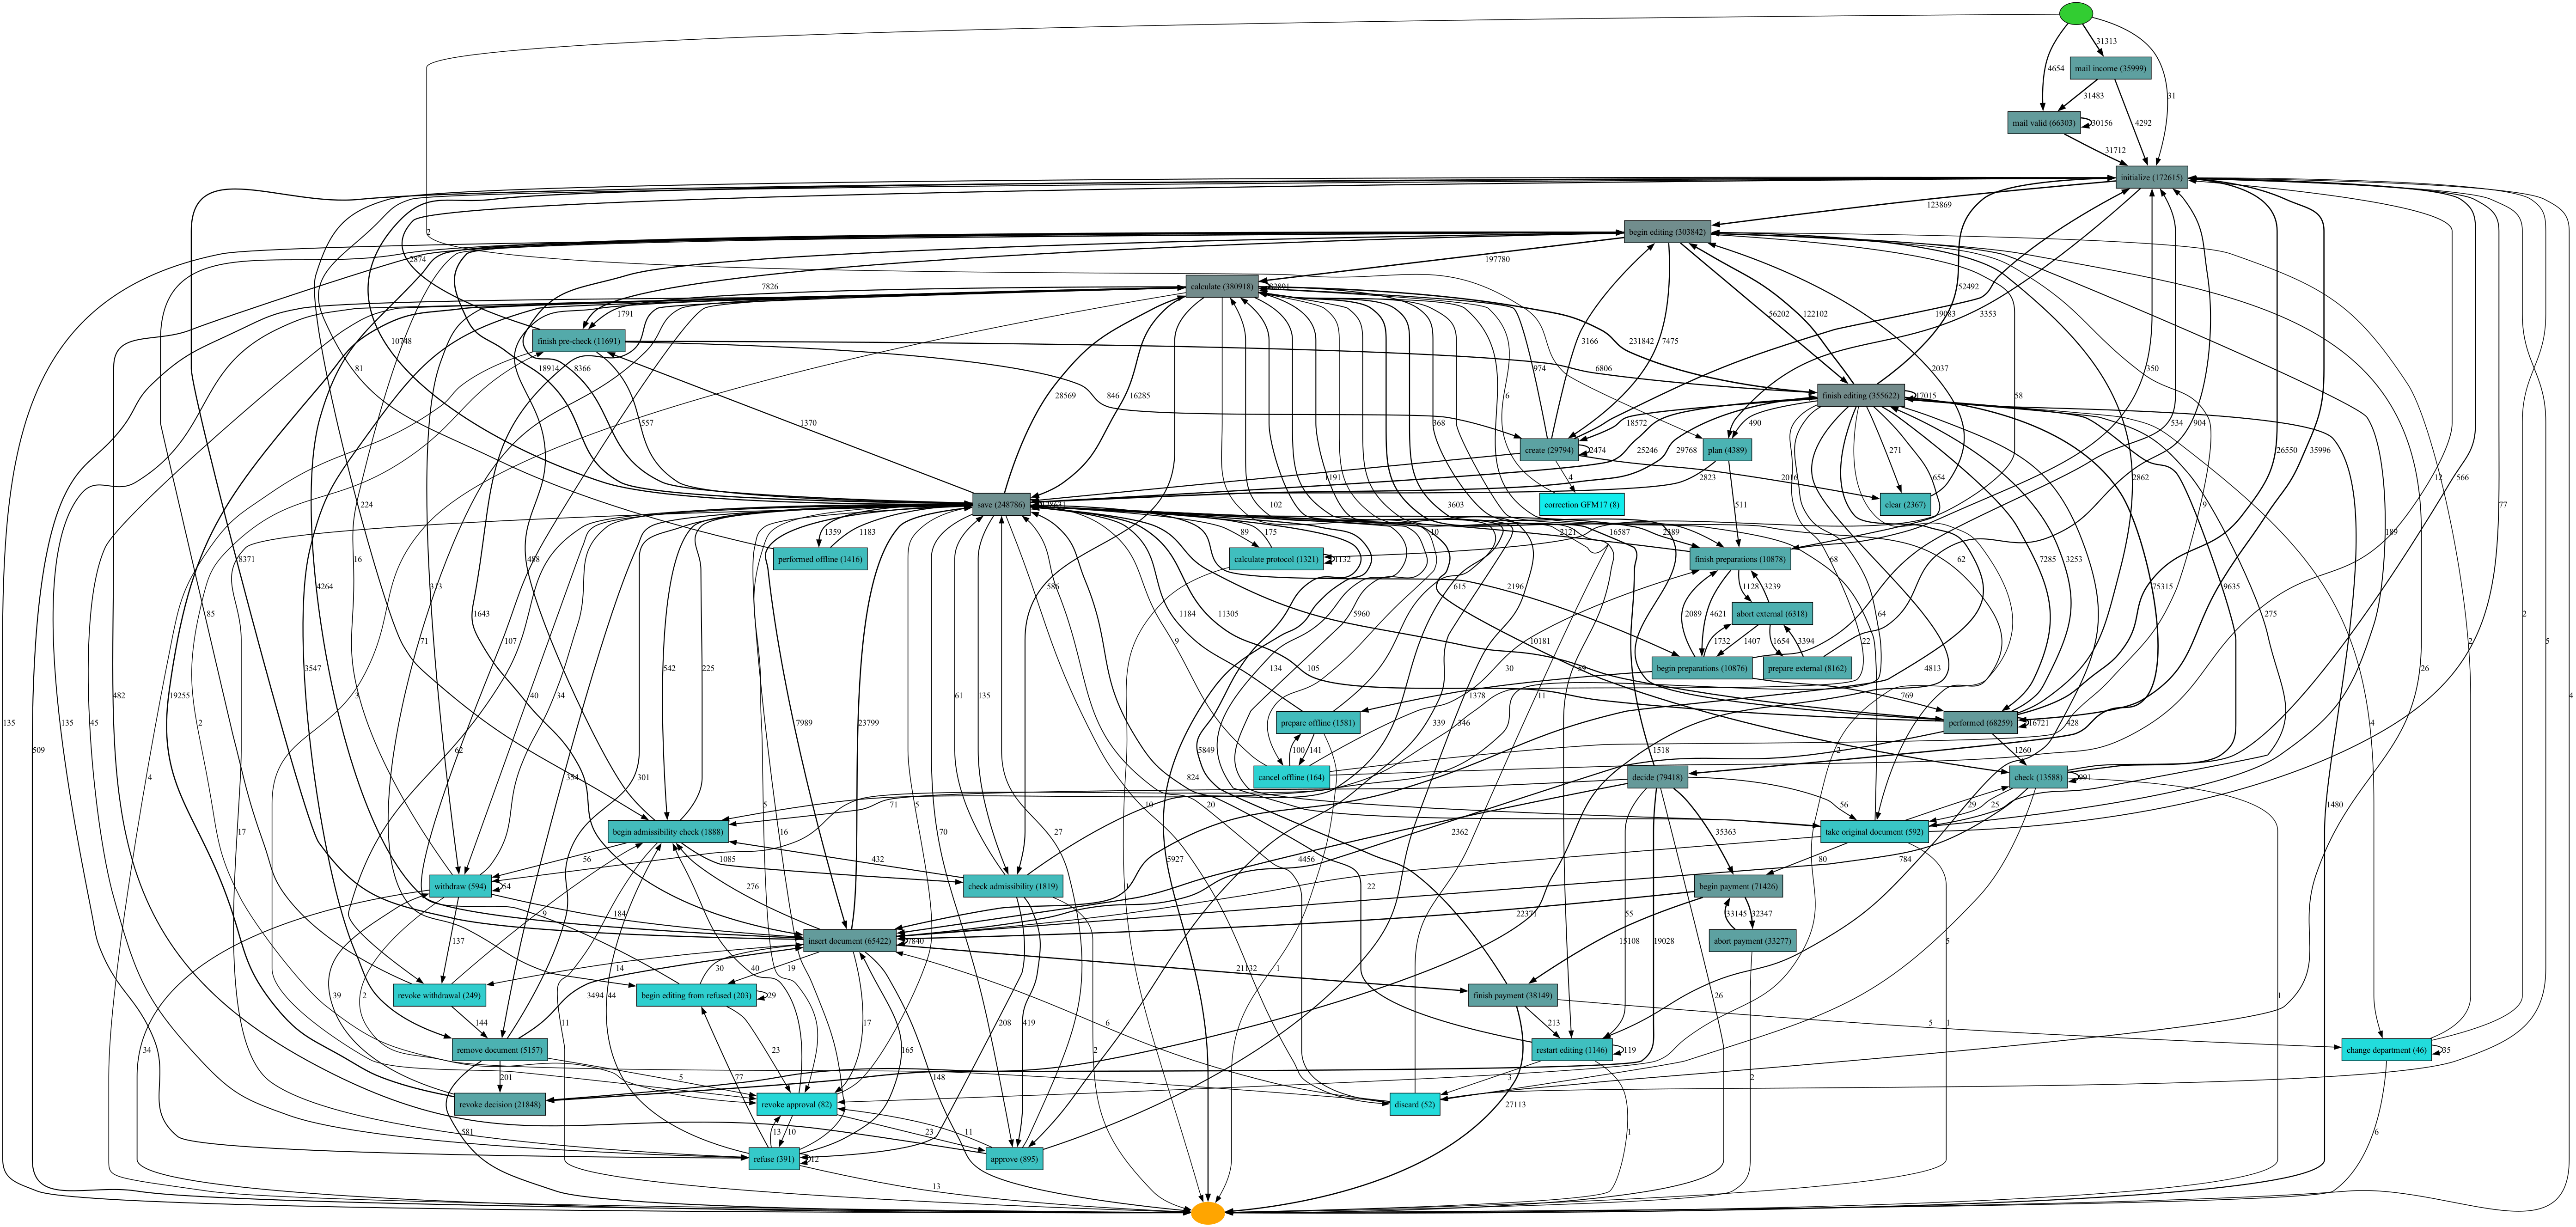

In [28]:
def visualize_process(df_subset, title):
    df_pm = df_subset[[CASE_COL, ACT_COL, TIME_COL]].copy()
    df_pm.columns = ["case:concept:name", "concept:name", "time:timestamp"]
    df_pm = dataframe_utils.convert_timestamp_columns_in_df(df_pm)
    event_log = log_converter.apply(df_pm)
    heu_net = heuristics_miner.apply_heu(event_log)
    gviz = hn_visualizer.apply(heu_net)
    print(f"\n--- {title} ---")
    hn_visualizer.view(gviz)

visualize_process(df_cleaned, "Overall Process Model")

#### Fewest Activities Cases — streamlined paths (minimal steps)

The simplest cases are visualized to identify ideal execution paths with minimal rework.


--- Fewest Activities — Process Model ---


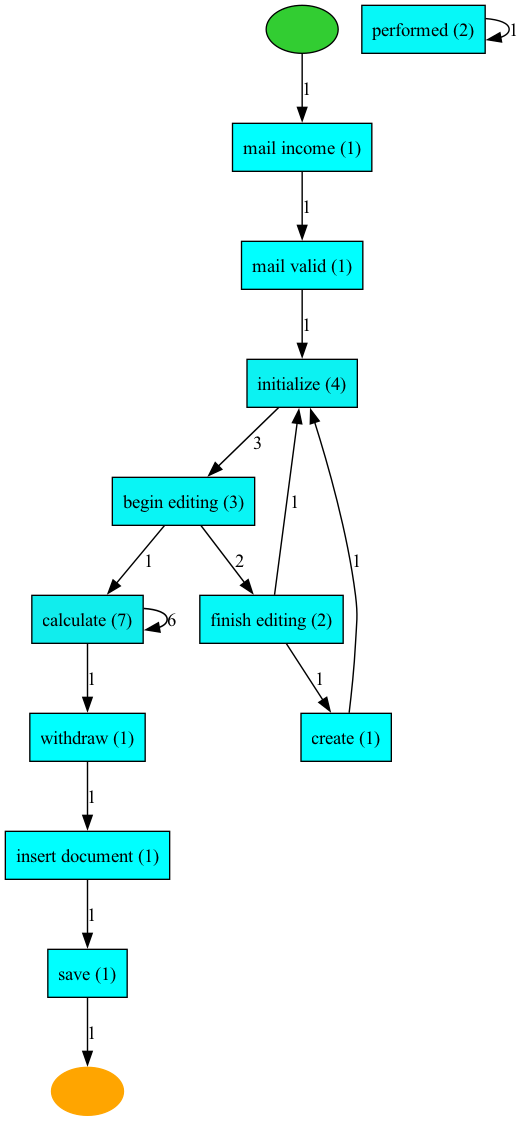

In [29]:
# Visualize subset: fewest activities (uses examples from Step 3.6)
subset_df = pd.concat(examples["fewest_activities_traces"], ignore_index=True)
visualize_process(subset_df, "Fewest Activities — Process Model")

#### Most Activities Cases — complex paths (loops/rework likely)

The most complex cases are visualized to highlight deviations, rework loops, or excessive manual handling.


--- Most Activities — Process Model ---


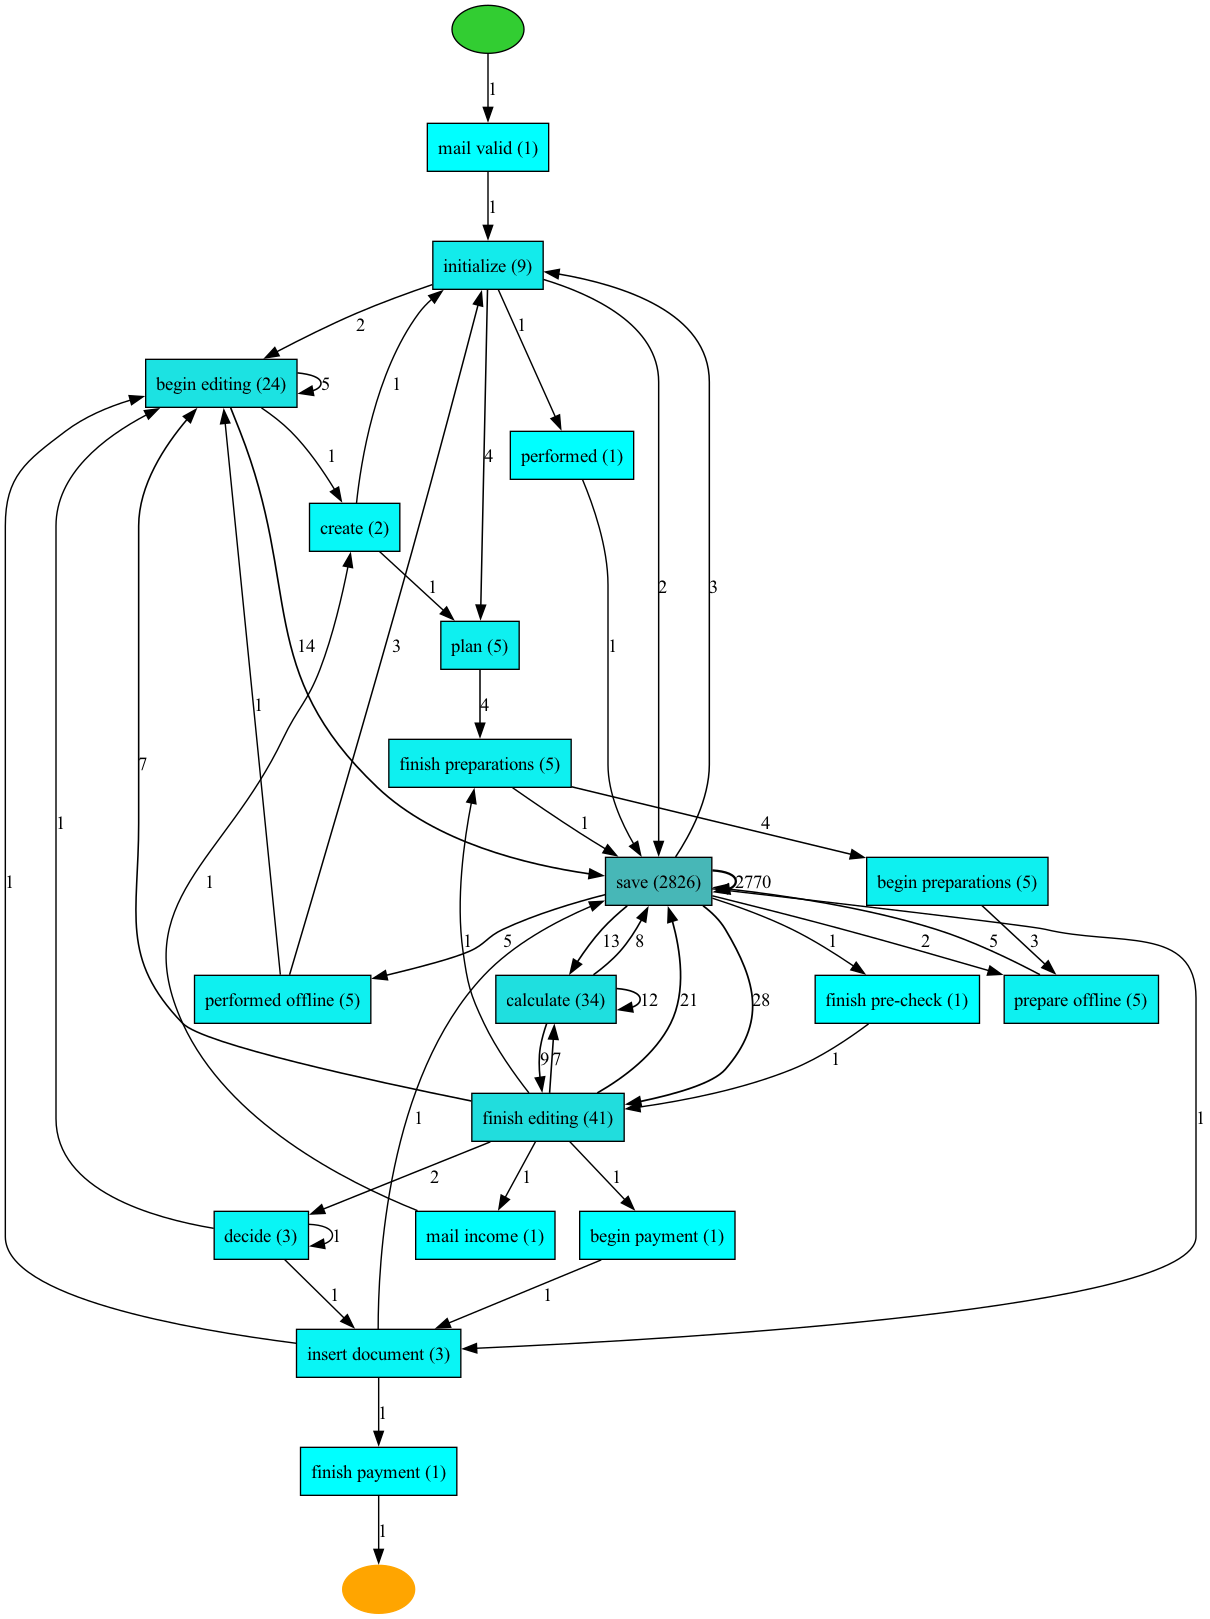

In [30]:
# Visualize subset: most activities
subset_df = pd.concat(examples["most_activities_traces"], ignore_index=True)
visualize_process(subset_df, "Most Activities — Process Model")

#### Shortest Duration Cases — fastest executions

The cases with the shortest completion time are displayed, often representing automated or optimized workflows.



--- Shortest Duration — Process Model ---


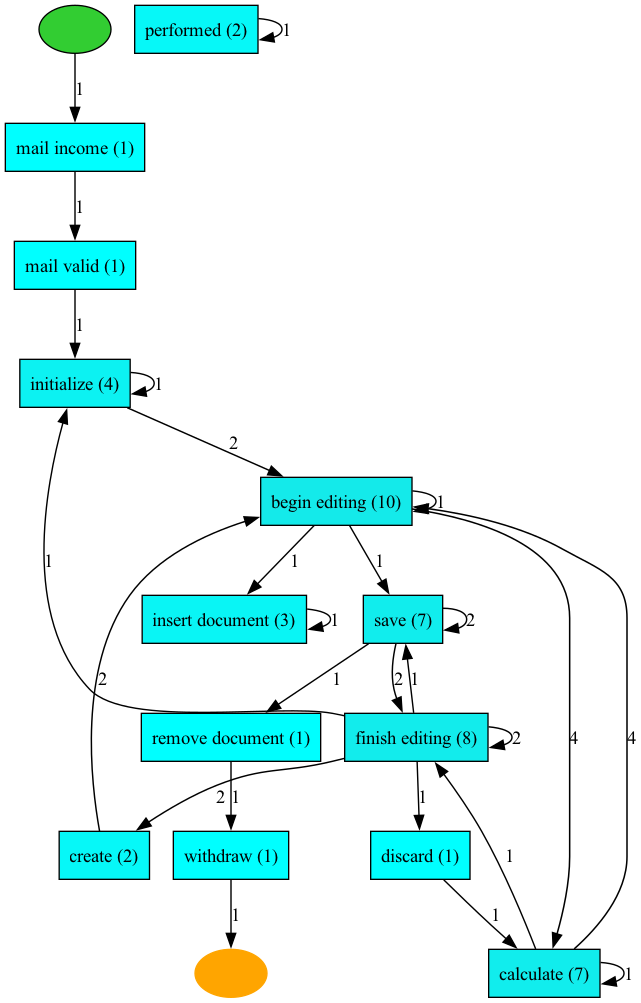

In [31]:
# Visualize subset: shortest duration
subset_df = pd.concat(examples["shortest_duration_traces"], ignore_index=True)
visualize_process(subset_df, "Shortest Duration — Process Model")

#### Longest Duration Cases — slow executions / bottlenecks

Cases with the longest duration are analyzed to locate bottlenecks or dependencies causing extended delays.


--- Longest Duration — Process Model ---


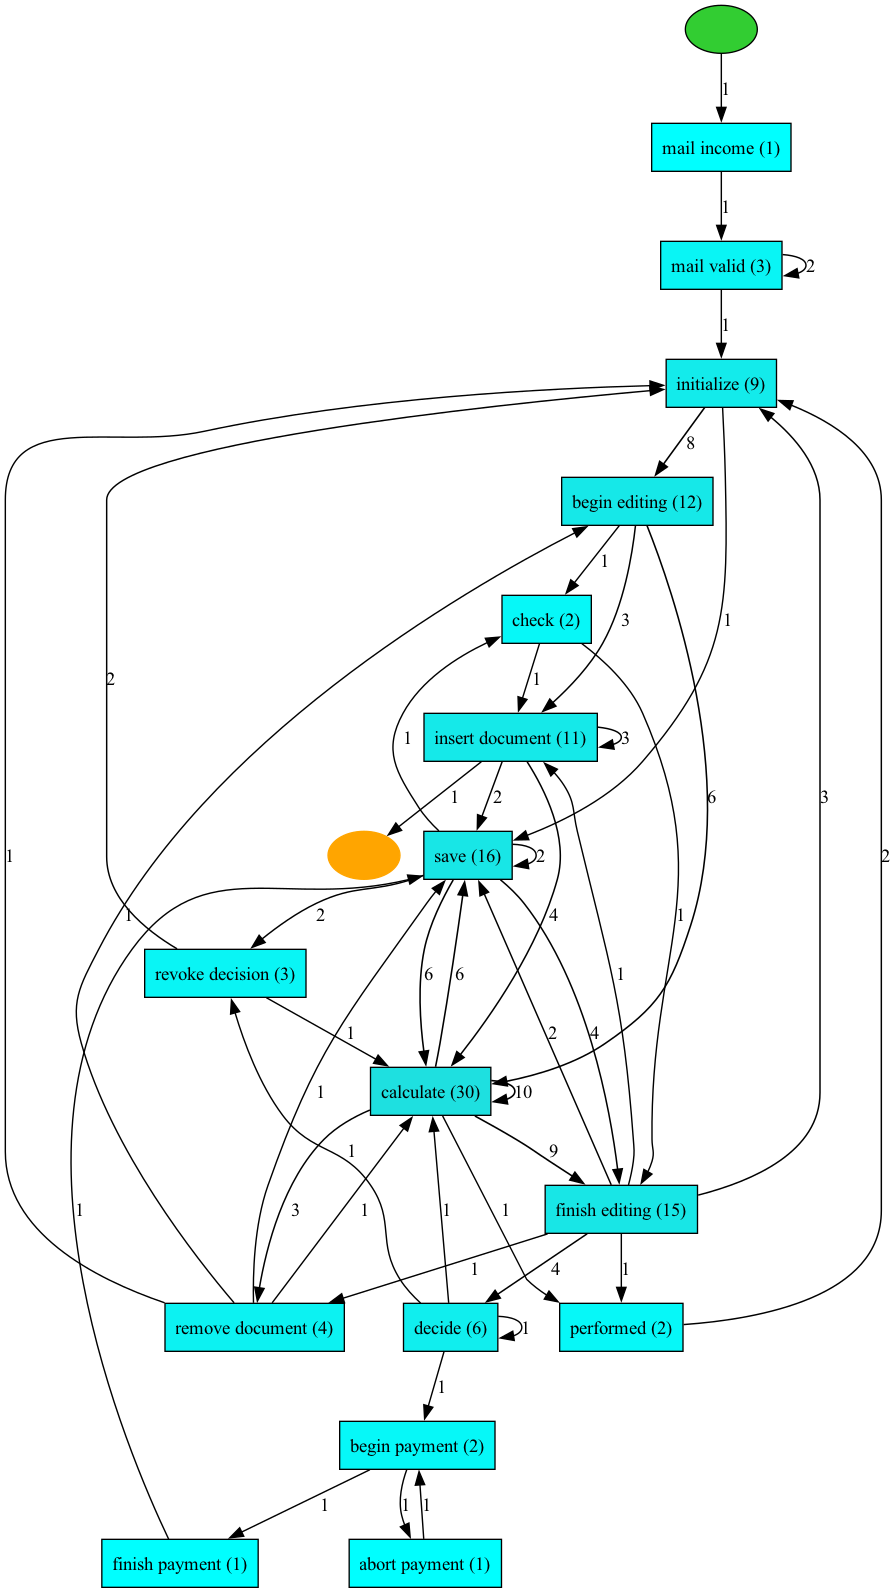

In [32]:
# Visualize subset: longest duration
subset_df = pd.concat(examples["longest_duration_traces"], ignore_index=True)
visualize_process(subset_df, "Longest Duration — Process Model")

## 4 — Case-Level Preprocessing Pipelines

### 4.0 — Setup & Target

The event log is ordered chronologically per case, and a target variable `target_success` is created.  
A case is labeled as successful only if all its events are marked as successful.  

This transformation prepares the data for case-level machine learning.

In [33]:
# Column aliases
CASE_COL    = 'case:concept:name'
TIME_COL    = 'time:timestamp'
ACT_COL     = 'activity'
SUCCESS_COL = 'success'

# Ensure ordering and event index
df_cleaned = df_cleaned.dropna(subset=[CASE_COL, ACT_COL, TIME_COL]).sort_values([CASE_COL, TIME_COL]).copy()
df_cleaned['event_idx'] = df_cleaned.groupby(CASE_COL).cumcount()


def make_case_target(dfc, strategy="all_success", end_activities=None):
    """
    strategy:
      - 'all_success': 1 only if ALL events success=True (0 if ANY failed)
      - 'last_event' : 1 if LAST event success=True
      - 'end_event_rule': 1 if LAST activity in end_activities AND success=True
    """
    if strategy == "all_success":
        ser = dfc.groupby(CASE_COL)[SUCCESS_COL].agg(lambda s: int(s.all()))
        return ser.to_frame("target_success")

    if strategy == "last_event":
        last = (dfc.sort_values([CASE_COL, TIME_COL])
                   .groupby(CASE_COL).tail(1)[[CASE_COL, SUCCESS_COL]])
        return last.rename(columns={SUCCESS_COL: "target_success"}).set_index(CASE_COL)

    if strategy == "end_event_rule":
        assert end_activities, "Provide end_activities list"
        last = (dfc.sort_values([CASE_COL, TIME_COL])
                   .groupby(CASE_COL).tail(1)[[CASE_COL, ACT_COL, SUCCESS_COL]])
        last["target_success"] = (last[ACT_COL].isin(end_activities) & last[SUCCESS_COL]).astype(int)
        return last.set_index(CASE_COL)[["target_success"]]

    raise ValueError("Unknown strategy")

# <<< choose your wanted label definition here >>>
case_target = make_case_target(df_cleaned, strategy="all_success")

# quick distribution
print(case_target["target_success"].value_counts())

1    24863
0    11137
Name: target_success, dtype: int64


### 4.1 — Numeric-Only Case Table + Preprocessor

Numeric features are aggregated per case, including:
- Event count, duration, and time gaps,  
- Case-level numeric and boolean flags.  

Boolean columns are converted to binary (0/1).  
The department field is kept as a categorical variable to capture organizational context.  

A preprocessing pipeline is defined:
- Median imputation and standard scaling for numeric features,  
- One-hot encoding for department categories.  

This pipeline standardizes numerical input and prepares it for modeling.

In [34]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

def build_case_numeric_bool_to_int(dfc: pd.DataFrame) -> pd.DataFrame:
    # base metrics
    base = dfc.groupby(CASE_COL).agg(
        n_events   =(ACT_COL,'size'),
        start_time =(TIME_COL,'min'),
        end_time   =(TIME_COL,'max')
    )
    base['duration_hours'] = (base['end_time'] - base['start_time']).dt.total_seconds()/3600

    # gaps
    tmp = dfc.sort_values([CASE_COL, TIME_COL]).copy()
    tmp['next_time'] = tmp.groupby(CASE_COL)[TIME_COL].shift(-1)
    gaps = (tmp['next_time'] - tmp[TIME_COL]).dt.total_seconds()/3600
    gap_stats = gaps.groupby(tmp[CASE_COL]).agg(['mean','median','std']).rename(
        columns={'mean':'gap_mean_h','median':'gap_median_h','std':'gap_std_h'}
    )

    # case-level numeric/bool (+ keep department as object)
    case_cols = [c for c in dfc.columns if c.startswith('case:') and c != CASE_COL]
    case_scalar = (
        dfc.groupby(CASE_COL)[case_cols].first()
           .select_dtypes(include=['float64','int64','bool','object'])
           .copy()
    )
    # bool → 0/1
    bool_cols = case_scalar.select_dtypes(include=['bool']).columns.tolist()
    if bool_cols:
        case_scalar[bool_cols] = case_scalar[bool_cols].astype('int8')

    # drop ID-like objects but KEEP department if present
    if 'case:department' in case_scalar.columns:
        obj_cols = case_scalar.select_dtypes(include=['object']).columns.tolist()
        drop_ids = [c for c in obj_cols if c != 'case:department' and any(k in c.lower() for k in ['uuid','id','identity','docid','concept:name'])]
        case_scalar = case_scalar.drop(columns=drop_ids, errors='ignore')
    else:
        case_scalar = case_scalar.select_dtypes(include=['float64','int64','int8'])

    # join pieces
    num_tbl = base.join([gap_stats, case_scalar], how='left').fillna(0)
    num_tbl = num_tbl.join(case_target, how='left').reset_index()

    return num_tbl

# build
num_tbl = build_case_numeric_bool_to_int(df_cleaned)
y_num   = num_tbl['target_success'].astype(int)
X_num   = num_tbl.drop(columns=['target_success','start_time','end_time'], errors='ignore')

# Numeric preprocessor: impute+scale numbers, **OHE department**
num_feature_cols = X_num.select_dtypes(include=['number']).columns.tolist()
cat_feature_cols = [c for c in ['case:department'] if c in X_num.columns]

numeric_preprocessor = ColumnTransformer([
    ('num',  Pipeline([('imp', SimpleImputer(strategy='median')), ('scaler', StandardScaler())]), num_feature_cols),
    ('dept', OneHotEncoder(handle_unknown='ignore', min_frequency=50), cat_feature_cols)
], remainder='drop')

print("X_num shape:", X_num.shape, "| y_num:", y_num.shape)

X_num shape: (36000, 60) | y_num: (36000,)


### 4.2 — Text-Only Case Table + Preprocessor

Selected textual attributes are combined into a single field, `text_doc`.  
Columns included are defined through a variable `TEXT_COLUMNS`, allowing flexibility.  
The text is lowercased, stripped, and any note equal to “none” is removed to eliminate placeholders.  

The preprocessing pipeline applies:
- TF-IDF vectorization (unigrams and bigrams),  
- Dimensionality reduction through Truncated SVD (300 components).  

This creates a compact numerical representation of textual semantics suitable for machine learning and explainable AI.

In [35]:
# 👇 You can edit this list anytime
TEXT_COLUMNS = [
    'doctype',
    'subprocess',
    'activity',
    'note',
    'concept:name',
    'lifecycle:transition'
]
# swap to note_cleaned if available
if 'note_cleaned' in df_cleaned.columns and 'note' in TEXT_COLUMNS:
    TEXT_COLUMNS = [c if c!='note' else 'note_cleaned' for c in TEXT_COLUMNS]
# keep existing cols only
TEXT_COLUMNS = [c for c in TEXT_COLUMNS if c in df_cleaned.columns]

def _clean_txt(x: str, is_note=False) -> str:
    s = str(x).lower().strip()
    if is_note and s == 'none':
        return ''
    s = re.sub(r'\s+', ' ', s)
    return s

def build_case_text_from_cols(dfc, cols):
    d = dfc[[CASE_COL] + cols].copy()
    for c in cols:
        d[c] = d[c].astype(str).map(lambda v: _clean_txt(v, is_note=(c in ['note','note_cleaned'])))
    per_col = [d.groupby(CASE_COL)[c].apply(lambda s: ' '.join([t for t in s if t])).rename(c) for c in cols]
    text_per_case = pd.concat(per_col, axis=1).fillna('')
    text_per_case['text_doc'] = text_per_case.apply(lambda r: ' | '.join([r[c] for c in cols if r[c]]), axis=1)
    text_per_case['text_doc'] = text_per_case['text_doc'].str.replace(r'\s+', ' ', regex=True).str.strip(' |')
    return text_per_case[['text_doc']].join(case_target, how='left').reset_index()

text_tbl = build_case_text_from_cols(df_cleaned, TEXT_COLUMNS)
y_text   = text_tbl['target_success'].astype(int)
X_text   = text_tbl['text_doc'].fillna('')

# Text preprocessor (letters ≥3, no digits) + SVD reduction
text_preprocessor = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=15000, ngram_range=(1,2), min_df=5,
        token_pattern=r'(?u)\b[^\W\d_]{3,}\b',
        strip_accents='unicode', lowercase=True
    )),
    ('svd', TruncatedSVD(n_components=300, random_state=42))
])

print("TEXT_COLUMNS:", TEXT_COLUMNS)
print("X_text length:", len(X_text), "| y_text:", y_text.shape)


TEXT_COLUMNS: ['doctype', 'subprocess', 'activity', 'note_cleaned', 'concept:name', 'lifecycle:transition']
X_text length: 36000 | y_text: (36000,)


### 4.3 — Combined Case Table + Preprocessor

The numeric and text tables are merged by case identifier, with optional addition of `start_activity` and `end_activity`.  

The combined preprocessor consists of:
- Imputation and scaling for numeric variables,  
- One-hot encoding for categorical variables (department, start/end activity),  
- TF-IDF + SVD transformation for text.  

This unified pipeline enables integrated modeling of structured process data and textual context.

In [36]:
# start/end activity
starts = (df_cleaned.groupby(CASE_COL).head(1)[[CASE_COL, ACT_COL]]
          .rename(columns={ACT_COL:'start_activity'}))
ends   = (df_cleaned.groupby(CASE_COL).tail(1)[[CASE_COL, ACT_COL]]
          .rename(columns={ACT_COL:'end_activity'}))
cats = starts.merge(ends, on=CASE_COL, how='outer')

# join numeric + cats + text
combined = (
    num_tbl[[CASE_COL,'target_success'] + [c for c in num_tbl.columns
                                           if c not in [CASE_COL,'target_success','start_time','end_time']]]
    .merge(cats, on=CASE_COL, how='left')
    .merge(text_tbl[[CASE_COL,'text_doc']], on=CASE_COL, how='left')
)

y_combined = combined['target_success'].astype(int)
feature_cols_num = combined.select_dtypes(include=['number']).columns.tolist()
if 'target_success' in feature_cols_num:
    feature_cols_num.remove('target_success')
feature_cols_cat = [c for c in ['start_activity','end_activity','case:department'] if c in combined.columns]
feature_cols_txt = ['text_doc']

X_combined = combined[feature_cols_num + feature_cols_cat + feature_cols_txt].drop(columns=['target_success'], errors='ignore')

combined_preprocessor = ColumnTransformer([
    ('num',  Pipeline([
        ('imp', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), feature_cols_num),

    ('cat',  Pipeline([
        ('imp', SimpleImputer(strategy='most_frequent')),
        ('ohe', OneHotEncoder(handle_unknown='ignore', min_frequency=50))
    ]), feature_cols_cat),

    ('txt',  Pipeline([
        ('tfidf', TfidfVectorizer(
            max_features=15000, ngram_range=(1,2), min_df=5,
            token_pattern=r'(?u)\b[^\W\d_]{3,}\b',
            strip_accents='unicode', lowercase=True)),
        ('svd', TruncatedSVD(n_components=300, random_state=42))
    ]), 'text_doc')
], remainder='drop')

print("X_combined shape:", X_combined.shape, "| y_combined:", y_combined.shape)

X_combined shape: (36000, 60) | y_combined: (36000,)


### 4.4 — Sanity Check

Feature and target dimensions are verified to confirm correct merging and encoding.  

The purpose of this step is to ensure that:
- All features are numeric after preprocessing,  
- No column duplication or leakage occurs,  
- The target column is excluded from the input features.  

Successful validation confirms readiness for model training.

In [37]:
print("✅ Prepared datasets & preprocessors")
print("- Numeric:  ", X_num.shape,      "| y:", y_num.shape,      "| preproc:", type(numeric_preprocessor).__name__)
print("- Text:     ", len(X_text),       "| y:", y_text.shape,     "| preproc:", type(text_preprocessor).__name__)
print("- Combined: ", X_combined.shape,  "| y:", y_combined.shape, "| preproc:", type(combined_preprocessor).__name__)

✅ Prepared datasets & preprocessors
- Numeric:   (36000, 60) | y: (36000,) | preproc: ColumnTransformer
- Text:      36000 | y: (36000,) | preproc: Pipeline
- Combined:  (36000, 60) | y: (36000,) | preproc: ColumnTransformer


In [38]:
X_num

case:concept:name  n_events  duration_hours  gap_mean_h  gap_median_h  \
0      0002505cb62792e4        56    19887.905920  361.598289      0.147578   
1      0002a55a6130cec8        40     7375.696206  189.120416     17.510492   
2      0004ff62053a60ce        51    11195.946389  223.918928      1.282065   
3      000612b48d30de74       111    11939.796785  108.543607      0.499632   
4      0006cc909ce508b0        46     9921.415278  220.475895     20.819939   
...                 ...       ...             ...         ...           ...   
35995  fffa3cf2546632a2        47     5942.888121  129.193220     18.586673   
35996  fffa4b3264750002       208    11513.006944   55.618391      0.013585   
35997  fffa93db29ee0841        49     5751.192484  119.816510      8.262441   
35998  fffab10d958a3e4d        39     5774.201432  151.952669     20.412416   
35999  fffadf8d083df3d5        65    17486.122579  273.220665      0.003570   

         gap_std_h  case:young farmer  case:selected_random  \
0      1736.086201                  0                     0   
1       397.552263                  0                     0   
2       683.270204                  0                     0   
3       297.878622                  0                     0   
4       628.300108                  0                     0   
...            ...                ...                   ...   
35995   284.707786                  0                     0   
35996   331.605169                  0                     1   
35997   228.319871                  0                     0   
35998   264.001798                  0                     0   
35999  1001.157220                  0                     0   

       case:penalty_AJLP  case:application  ...  case:penalty_JLP7  case:year  \
0                      0  0002505cb62792e4  ...                  0       2015   
1                      0  0002a55a6130cec8  ...                  0       2015   
2                      0  0004ff62053a60ce  ...                  0       2015   
3                      0  000612b48d30de74  ...                  0       2015   
4                      0  0006cc909ce508b0  ...                  0       2016   
...                  ...               ...  ...                ...        ...   
35995                  0  fffa3cf2546632a2  ...                  0       2016   
35996                  0  fffa4b3264750002  ...                  0       2015   
35997                  0  fffa93db29ee0841  ...                  0       2016   
35998                  0  fffab10d958a3e4d  ...                  0       2016   
35999                  0  fffadf8d083df3d5  ...                  0       2015   

       case:penalty_JLP5  case:penalty_JLP2 case:penalty_JLP3  \
0                      0                  0                 0   
1                      0                  0                 0   
2                      0                  0                 0   
3                      0                  0                 0   
4                      0                  0                 0   
...                  ...                ...               ...   
35995                  0                  0                 0   
35996                  0                  0                 0   
35997                  0                  0                 0   
35998                  0                  0                 0   
35999                  0                  0                 0   

       case:number_parcels  case:penalty_JLP1  case:penalty_amount1  \
0                       22                  0                  0.00   
1                        3                  0                  0.00   
2                        1                  0                  0.00   
3                       32                  0                 86.95   
4                       29                  0                  0.00   
...                    ...                ...                   ...   
35995                   10                  0    

## 5 — Modeling & Evaluation (three independent pipelines)

### 5.0 — Metrics helper

Functions are defined to compute standard performance metrics: accuracy, F1-score, ROC-AUC, and the confusion matrix.  
This unified evaluation method ensures comparability across models.

In [39]:
def evaluate(y_true, y_pred, y_proba=None, title=""):
    if title: print(f"\n=== {title} ===")
    print("Accuracy :", round(accuracy_score(y_true, y_pred), 4))
    print("F1-score :", round(f1_score(y_true, y_pred), 4))
    if y_proba is not None:
        try:
            print("ROC-AUC  :", round(roc_auc_score(y_true, y_proba), 4))
        except Exception as e:
            print("ROC-AUC  : (n/a)", e)
    print("\nReport:\n", classification_report(y_true, y_pred, digits=4))
    print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))


### 5.1 — Model A: Numeric-only (uses X_num, y_num, numeric_preprocessor)

The numeric pipeline is trained with a Random Forest classifier.  
The pipeline performs median imputation and scaling before training.  

This model evaluates predictive power based solely on structured process data such as duration and activity count.

In [40]:
RANDOM_STATE = 42

Xn_train, Xn_test, yn_train, yn_test = train_test_split(
    X_num, y_num, test_size=0.2, random_state=RANDOM_STATE, stratify=y_num
)

numeric_model = Pipeline(steps=[
    ('imputer', numeric_preprocessor),
    ('clf', RandomForestClassifier(
        n_estimators=300, max_depth=None, n_jobs=-1, random_state=RANDOM_STATE
    ))
])

numeric_model.fit(Xn_train, yn_train)
yn_pred  = numeric_model.predict(Xn_test)
yn_proba = numeric_model.predict_proba(Xn_test)[:,1]

evaluate(yn_test, yn_pred, yn_proba, title="Numeric-only")


=== Numeric-only ===
Accuracy : 0.9067
F1-score : 0.9348
ROC-AUC  : 0.9544

Report:
               precision    recall  f1-score   support

           0     0.9156    0.7692    0.8360      2227
           1     0.9035    0.9682    0.9348      4973

    accuracy                         0.9067      7200
   macro avg     0.9095    0.8687    0.8854      7200
weighted avg     0.9073    0.9067    0.9042      7200

Confusion matrix:
 [[1713  514]
 [ 158 4815]]


### 5.2 — Model B: Text-only (uses X_text, y_text, text_preprocessor)

The text pipeline is trained using a Logistic Regression classifier on the TF-IDF+SVD representation.  
This isolates the influence of textual information on process outcomes.  

Performance is assessed with the same metrics for comparability.

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

Xt_train, Xt_test, yt_train, yt_test = train_test_split(
    X_text, y_text, test_size=0.2, random_state=RANDOM_STATE, stratify=y_text
)

text_model = Pipeline(steps=[
    ('tfidf', text_preprocessor),  # from Step 4
    ('clf', LogisticRegression(
        max_iter=3000, solver='saga', penalty='l2', random_state=RANDOM_STATE
    ))
])

text_model.fit(Xt_train, yt_train)
yt_pred  = text_model.predict(Xt_test)
yt_proba = text_model.predict_proba(Xt_test)[:,1]

evaluate(yt_test, yt_pred, yt_proba, title="Text-only")



=== Text-only ===
Accuracy : 0.9265
F1-score : 0.9484
ROC-AUC  : 0.9757

Report:
               precision    recall  f1-score   support

           0     0.9408    0.8137    0.8726      2227
           1     0.9213    0.9771    0.9484      4973

    accuracy                         0.9265      7200
   macro avg     0.9311    0.8954    0.9105      7200
weighted avg     0.9273    0.9265    0.9249      7200

Confusion matrix:
 [[1812  415]
 [ 114 4859]]


### 5.3 — Model C: Combined (uses X_combined, y_combined, combined_preprocessor)

The combined pipeline integrates numeric, categorical, and textual features.  
Logistic Regression is used to jointly model process and semantic information.  

The comparison of results across the three pipelines indicates whether textual data provides additional predictive value beyond structured attributes.

In [42]:
Xc_train, Xc_test, yc_train, yc_test = train_test_split(
    X_combined, y_combined, test_size=0.2, random_state=RANDOM_STATE, stratify=y_combined
)

combined_model = Pipeline(steps=[
    ('prep', combined_preprocessor),
    ('clf', LogisticRegression(
        max_iter=4000, solver='saga', penalty='l2', random_state=RANDOM_STATE
    ))
])

combined_model.fit(Xc_train, yc_train)
yc_pred  = combined_model.predict(Xc_test)
yc_proba = combined_model.predict_proba(Xc_test)[:,1]

evaluate(yc_test, yc_pred, yc_proba, title="Combined (numeric + categorical + text)")

The max_iter was reached which means the coef_ did not converge



=== Combined (numeric + categorical + text) ===
Accuracy : 0.921
F1-score : 0.9443
ROC-AUC  : 0.9676

Report:
               precision    recall  f1-score   support

           0     0.9238    0.8114    0.8640      2227
           1     0.9199    0.9700    0.9443      4973

    accuracy                         0.9210      7200
   macro avg     0.9219    0.8907    0.9041      7200
weighted avg     0.9211    0.9210    0.9195      7200

Confusion matrix:
 [[1807  420]
 [ 149 4824]]


### 5.4 - Results Visualization of models

#### 5.4.1 ROC & PR curves (overlay for the three models)

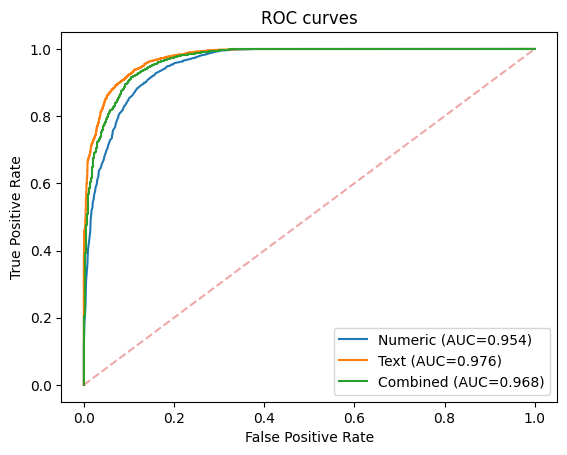

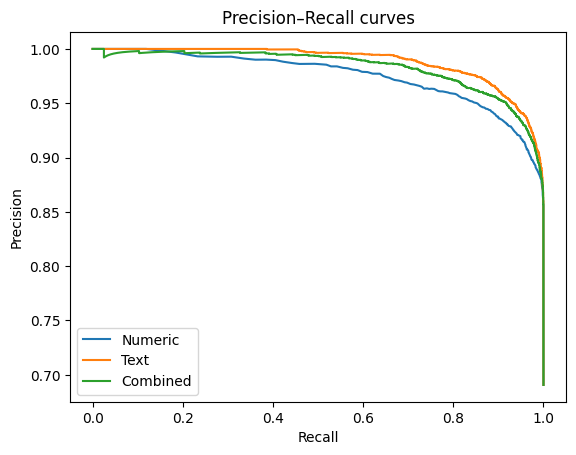

In [43]:
# Title: ROC & PR curves (overlay)

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, auc

# These must already exist from your Step 5:
# numeric_model, text_model, combined_model
# Xn_test, yn_test ; Xt_test, yt_test ; Xc_test, yc_test

proba_num = numeric_model.predict_proba(Xn_test)[:,1]
proba_txt = text_model.predict_proba(Xt_test)[:,1]
proba_cmb = combined_model.predict_proba(Xc_test)[:,1]

# ROC
fpr_n, tpr_n, _ = roc_curve(yn_test, proba_num)
fpr_t, tpr_t, _ = roc_curve(yt_test, proba_txt)
fpr_c, tpr_c, _ = roc_curve(yc_test, proba_cmb)

plt.figure()
plt.plot(fpr_n, tpr_n, label=f'Numeric (AUC={auc(fpr_n,tpr_n):.3f})')
plt.plot(fpr_t, tpr_t, label=f'Text (AUC={auc(fpr_t,tpr_t):.3f})')
plt.plot(fpr_c, tpr_c, label=f'Combined (AUC={auc(fpr_c,tpr_c):.3f})')
plt.plot([0,1],[0,1],'--', alpha=0.4)
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC curves'); plt.legend(); plt.show()

# PR
prec_n, rec_n, _ = precision_recall_curve(yn_test, proba_num)
prec_t, rec_t, _ = precision_recall_curve(yt_test, proba_txt)
prec_c, rec_c, _ = precision_recall_curve(yc_test, proba_cmb)

plt.figure()
plt.plot(rec_n, prec_n, label='Numeric')
plt.plot(rec_t, prec_t, label='Text')
plt.plot(rec_c, prec_c, label='Combined')
plt.xlabel('Recall'); plt.ylabel('Precision')
plt.title('Precision–Recall curves'); plt.legend(); plt.show()


#### 5.4.2 Numeric model — permutation importance (top 20)

In [44]:
# Title: Numeric model — permutation importance (top 20)

from sklearn.inspection import permutation_importance
import pandas as pd

# Get feature names as actually fed to the model
num_ct = numeric_model.named_steps['imputer']  # ColumnTransformer
# Numeric block names
num_cols = num_ct.transformers_[0][2] if len(num_ct.transformers_) > 0 else []
# Dept OHE names (if present)
dept_names = []
for name, transformer, cols in num_ct.transformers_:
    if name == 'dept':
        ohe = transformer
        try:
            dept_names = list(ohe.get_feature_names_out(cols))
        except:
            dept_names = list(cols)

feat_names_num = list(num_cols) + list(dept_names)

r = permutation_importance(numeric_model, Xn_test, yn_test, n_repeats=5, random_state=42, n_jobs=-1)
imp = pd.DataFrame({'feature': feat_names_num, 'importance': r.importances_mean}).sort_values('importance', ascending=False)
display(imp.head(20))


/Users/victor/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/utils/__init__.py:15: UserWarning: A NumPy version >=1.23.5 and <2.5.0 is required for this version of SciPy (detected version 1.23.2)
  from scipy.sparse import issparse
/Users/victor/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/utils/__init__.py:15: UserWarning: A NumPy version >=1.23.5 and <2.5.0 is required for this version of SciPy (detected version 1.23.2)
  from scipy.sparse import issparse
/Users/victor/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/utils/__init__.py:15: UserWarning: A NumPy version >=1.23.5 and <2.5.0 is required for this version of SciPy (detected version 1.23.2)
  from scipy.sparse import issparse
/Users/victor/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/utils/__init__.py:15: UserWarning: A NumPy version >=1.23.5 and <2.5.0 is required for this version of SciPy (detected version 1.23.2)
  fr

feature  importance
51   case:number_parcels    0.235194
1         duration_hours    0.008222
18       case:penalty_CC    0.004000
59    case:department_e7    0.001722
4              gap_std_h    0.001556
57    case:department_6b    0.000750
3           gap_median_h    0.000556
7      case:penalty_AJLP    0.000389
39    case:basic payment    0.000222
13     case:small farmer    0.000194
56    case:department_4e    0.000139
52     case:penalty_JLP1    0.000139
30     case:penalty_AVBP    0.000139
40      case:penalty_B5F    0.000083
42  case:payment_actual0    0.000056
17    case:penalty_AVUVP    0.000028
28       case:penalty_B4    0.000028
6   case:selected_random    0.000028
12      case:risk_factor    0.000000
44   case:redistribution    0.000000

#### 5.4.3. Text model — top positive / negative terms

In [45]:
# Works with your exact pipeline:
# text_model = Pipeline([('tfidf', text_preprocessor), ('clf', LogisticRegression(...))])
# where text_preprocessor = Pipeline([('tfidf', TfidfVectorizer(...)), ('svd', TruncatedSVD(...))])

import numpy as np, pandas as pd

# Grab the inner vectorizer & SVD (nested inside the first step)
prep = text_model.named_steps['tfidf']          # this is your text_preprocessor (a Pipeline)
tfidf = prep.named_steps['tfidf']               # inner TfidfVectorizer
svd   = prep.named_steps['svd']                 # inner TruncatedSVD
clf   = text_model.named_steps['clf']           # LogisticRegression

# Terms in the TF-IDF vocab
terms = np.array(tfidf.get_feature_names_out())  # shape: (n_terms,)

# Map classifier coefficients (in SVD space) back to TF-IDF terms:
# clf.coef_: (1, n_components); svd.components_: (n_components, n_terms)
coef_svd     = clf.coef_.ravel()
term_weights = coef_svd @ svd.components_       # shape: (n_terms,)

# Build tables
tw = pd.DataFrame({'term': terms, 'weight': term_weights})
top_pos = tw.sort_values('weight', ascending=False).head(30).reset_index(drop=True)
top_neg = tw.sort_values('weight', ascending=True ).head(30).reset_index(drop=True)

print("Top positive terms (push to success):")
display(top_pos)

print("\nTop negative terms (push to failure):")
display(top_neg)


Top positive terms (push to success):


term    weight
0                 automatic  7.488696
1       automatic automatic  7.332010
2                     begin  5.923910
3             begin editing  5.247987
4           performed begin  3.894707
5   application application  2.940630
6                initialize  2.605069
7          initialize begin  2.584863
8              create begin  2.281485
9                 main main  2.236925
10               save check  2.202070
11       editing initialize  2.111172
12         calculate remove  2.067448
13          restart editing  2.019542
14                  restart  2.019542
15            editing begin  1.897326
16      performed performed  1.856177
17              parcels geo  1.823518
18                save save  1.683752
19        income initialize  1.644443
20       application parcel  1.638193
21                     main  1.636214
22                performed  1.634745
23                  payment  1.578315
24              application  1.531646
25       document reference  1.517584
26           editing create  1.379598
27                   create  1.378029
28        declared declared  1.375119
29           calculate save  1.372259


Top negative terms (push to failure):


term     weight
0            decide decide -15.195116
1                 reported  -9.499355
2          decision revoke  -9.015785
3        reported reported  -7.452795
4              save finish  -6.823885
5           finish editing  -5.787302
6                   finish  -5.580664
7             editing save  -5.065883
8             document geo  -4.392665
9               geo parcel  -4.307094
10                     geo  -4.307094
11                  decide  -4.261264
12        performed finish  -3.178589
13                document  -3.022424
14         document insert  -2.627264
15               objection  -2.496409
16                  change  -2.470658
17           change change  -2.464609
18     calculate performed  -2.441727
19     objection objection  -2.408840
20                decision  -2.173743
21         revoke decision  -2.173743
22                  revoke  -2.162292
23  application department  -2.011421
24                  insert  -1.823033
25         insert document  -1.823033
26  applicant notification  -1.792542
27    reported application  -1.656176
28          editing insert  -1.593371
29    application reported  -1.565970

#### 5.4.4 Combined model — top features (num/cat/txt)

In [46]:
# Works with your fitted: combined_model = Pipeline([('prep', combined_preprocessor), ('clf', LogisticRegression(...))])

import numpy as np, pandas as pd

prep = combined_model.named_steps['prep']   # ColumnTransformer
clf  = combined_model.named_steps['clf']    # LogisticRegression

# 1) Get feature names directly from the ColumnTransformer (exact order & length)
feat_names = prep.get_feature_names_out()   # e.g., ['num__n_events', 'cat__start_activity_begin editing', 'txt__automatic', ...]

# 2) Make them prettier (optional)
pretty = []
for n in feat_names:
    if n.startswith('num__'):
        pretty.append(n.replace('num__', 'NUM::'))
    elif n.startswith('cat__'):
        pretty.append(n.replace('cat__', 'CAT::'))
    elif n.startswith('txt__'):
        pretty.append(n.replace('txt__', 'TXT::'))
    else:
        pretty.append(n)

# 3) Coefficients from the LR (aligned to the transformed feature space)
coef = clf.coef_.ravel()

# 4) Sanity check to avoid length mismatch errors
print(f"names: {len(pretty)} | coefs: {len(coef)}")
assert len(pretty) == len(coef), "Feature-name length != coef length. Check ColumnTransformer fit."

# 5) Build ranked table
feat_df = (pd.DataFrame({'feature': pretty, 'coef': coef})
             .sort_values('coef', ascending=False)
             .reset_index(drop=True))

print("Top positive features:")
display(feat_df.head(40))

print("\nTop negative features:")
display(feat_df.tail(40).iloc[::-1].reset_index(drop=True))


names: 371 | coefs: 371
Top positive features:


feature      coef
0                     TXT::truncatedsvd3  5.790396
1                    TXT::truncatedsvd12  3.613373
2                     TXT::truncatedsvd8  3.104035
3                     TXT::truncatedsvd6  1.534545
4                    TXT::truncatedsvd13  1.412264
5                    TXT::truncatedsvd50  1.052669
6                    TXT::truncatedsvd16  1.013187
7                    TXT::truncatedsvd52  0.996903
8                        NUM::gap_mean_h  0.914068
9                    TXT::truncatedsvd11  0.799113
10                   TXT::truncatedsvd40  0.649076
11               CAT::case:department_d4  0.593165
12                   TXT::truncatedsvd63  0.591490
13                   TXT::truncatedsvd53  0.591384
14                   TXT::truncatedsvd45  0.578887
15                   TXT::truncatedsvd51  0.542063
16                   TXT::truncatedsvd41  0.540988
17                   TXT::truncatedsvd95  0.490374
18                   TXT::truncatedsvd75  0.485233
19                   TXT::truncatedsvd46  0.476831
20        CAT::start_activity_mail valid  0.465454
21                   TXT::truncatedsvd90  0.437205
22                     NUM::gap_median_h  0.429639
23     CAT::end_activity_remove document  0.389449
24                   TXT::truncatedsvd99  0.371957
25                  TXT::truncatedsvd118  0.341474
26                   TXT::truncatedsvd88  0.336859
27                   TXT::truncatedsvd96  0.324383
28                CAT::end_activity_save  0.319554
29                   TXT::truncatedsvd37  0.310030
30                   TXT::truncatedsvd15  0.297676
31  CAT::end_activity_infrequent_sklearn  0.290264
32                   TXT::truncatedsvd77  0.254869
33                  TXT::truncatedsvd117  0.254003
34                   TXT::truncatedsvd61  0.236430
35               CAT::case:department_6b  0.236207
36                   TXT::truncatedsvd23  0.217377
37                  TXT::truncatedsvd121  0.210198
38                  TXT::truncatedsvd129  0.203115
39                  TXT::truncatedsvd133  0.196714


Top negative features:


feature      coef
0                 TXT::truncatedsvd14 -5.078189
1                  TXT::truncatedsvd2 -4.215377
2                  TXT::truncatedsvd4 -2.807052
3                 TXT::truncatedsvd24 -2.581458
4                  TXT::truncatedsvd7 -2.505012
5                  TXT::truncatedsvd9 -2.309210
6                  TXT::truncatedsvd5 -2.283116
7                      NUM::case:year -2.026088
8                 TXT::truncatedsvd25 -1.914745
9                  TXT::truncatedsvd1 -1.890728
10                TXT::truncatedsvd26 -1.762357
11                TXT::truncatedsvd60 -1.390735
12                TXT::truncatedsvd27 -1.113151
13                TXT::truncatedsvd64 -0.992089
14                TXT::truncatedsvd18 -0.951814
15                TXT::truncatedsvd49 -0.915960
16                TXT::truncatedsvd44 -0.800065
17                TXT::truncatedsvd21 -0.779289
18                TXT::truncatedsvd30 -0.745111
19                NUM::duration_hours -0.675243
20                TXT::truncatedsvd35 -0.586661
21                TXT::truncatedsvd65 -0.582749
22                TXT::truncatedsvd47 -0.577104
23                TXT::truncatedsvd38 -0.527524
24  CAT::end_activity_insert document -0.503979
25                TXT::truncatedsvd39 -0.499464
26               TXT::truncatedsvd107 -0.483395
27                TXT::truncatedsvd19 -0.475537
28               TXT::truncatedsvd135 -0.462960
29                TXT::truncatedsvd55 -0.444776
30                TXT::truncatedsvd67 -0.433901
31                TXT::truncatedsvd31 -0.420826
32               TXT::truncatedsvd100 -0.388927
33               TXT::truncatedsvd105 -0.363554
34               TXT::truncatedsvd115 -0.343418
35                TXT::truncatedsvd76 -0.341026
36                TXT::truncatedsvd81 -0.330538
37                TXT::truncatedsvd94 -0.328412
38                TXT::truncatedsvd36 -0.324546
39              NUM::case:penalty_BGP -0.318790

## 6 — Explainable AI (XAI) for Process Prediction Models

### 6.0 Setup – load SHAP and sample data

Explainability frameworks are loaded and data samples are prepared for analysis.  
This stage provides the foundation for both global (feature importance) and local (case-level) explanations.

In [47]:
from lime.lime_text import LimeTextExplainer
from lime.lime_tabular import LimeTabularExplainer
import numpy as np
import pandas as pd

### 6.1 LIME on the Text-only model (local explanation of one case)

LIME Text is applied to the Logistic Regression text model.  
The explainer highlights the words and phrases that most strongly influenced the model toward predicting success or failure for a specific case.  

Positive contributions indicate terms associated with success, while negative contributions represent risk or failure cues.  
The visualization displays these contributions directly in the text, facilitating interpretation of the model’s reasoning.

In [48]:
# expects: Xt_train, Xt_test, text_model from Step 5 (TF-IDF(+SVD) → Logistic)

def _text_predict_proba(text_list):
    # LIME expects an array-like of raw texts → proba matrix (n, 2)
    return text_model.predict_proba(pd.Series(text_list))

text_explainer = LimeTextExplainer(class_names=['failure','success'])

# pick one test doc to explain
i = Xt_test.sample(1, random_state=42).index[0]
doc = Xt_test.loc[i]

exp_text = text_explainer.explain_instance(
    text_instance=doc,
    classifier_fn=_text_predict_proba,
    num_features=15,
    labels=[1]  # explain class "success" (1). Use [0] to explain failure.
)

print("Predicted p(success):", float(text_model.predict_proba(pd.Series([doc]))[0,1]))
exp_text.show_in_notebook(text=True)
# Optional: save
# exp_text.save_to_file("/mnt/data/lime_text_example.html")


Predicted p(success): 0.9577620209641861


In [49]:
# --- LIME: Text-only local explanation (word-level) ---
from lime.lime_text import LimeTextExplainer
import pandas as pd
import numpy as np

# text_model = Pipeline([('tfidf'|text_preprocessor), ('clf', LogisticRegression(...))])
class_names = ['failure','success']
explainer_txt = LimeTextExplainer(class_names=class_names, random_state=RANDOM_STATE)

# pick a case to explain
i = 5  # change index to browse
doc = Xt_test.iloc[i]

# LIME expects a callable that accepts a list[str] and returns proba (n_samples, 2)
def _predict_text(texts):
    # text_model can take a Series or list and handle it
    return text_model.predict_proba(pd.Series(texts))

exp = explainer_txt.explain_instance(
    doc,
    _predict_text,
    num_features=20,      # number of highlighted tokens
    top_labels=2
)

print("Predicted proba [failure, success]:", text_model.predict_proba(pd.Series([doc]))[0])
# in-notebook visual
exp.show_in_notebook(text=True)

# Optional: save a standalone HTML
# exp.save_to_file("/mnt/data/lime_text_example.html")


Predicted proba [failure, success]: [0.02182053 0.97817947]


### 6.2 LIME Tabular — local explanation on the combined pipeline

In [50]:
# You already have:
X_train_num_df = pd.DataFrame(
    numeric_preprocessor.fit_transform(X_num),
    columns=numeric_preprocessor.get_feature_names_out()
)

explainer_num = LimeTabularExplainer(
    training_data=X_train_num_df.values,
    feature_names=X_train_num_df.columns.tolist(),
    class_names=['failure','success'],
    mode='classification',
    random_state=RANDOM_STATE
)

instance = X_train_num_df.iloc[0].values

# If numeric_model = Pipeline([('prep', ...), ('clf', <estimator>)])
clf = numeric_model.named_steps['clf']

def _predict_num(X):
    # X is already in transformed space; don't wrap with DataFrame or route through the preprocessor
    return clf.predict_proba(X)

exp = explainer_num.explain_instance(
    data_row=instance,
    predict_fn=_predict_num,
    num_features=20,
    top_labels=2
)


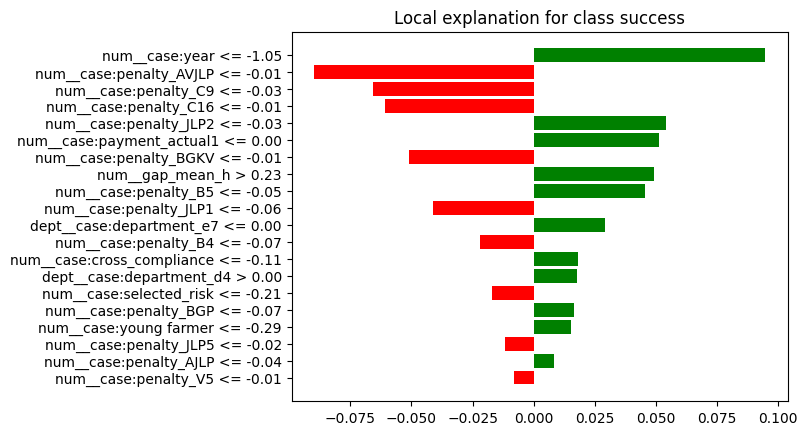

In [51]:
fig = exp.as_pyplot_figure()
import matplotlib.pyplot as plt
plt.show()

### SHAP (ready-to-run once your NumPy/Numba are compatible)

In [52]:
# Title: Token frequency by class (quick view) + SVD component top words

from collections import Counter
import numpy as np, pandas as pd

# Class-wise most common tokens
def most_common_tokens(texts, k=25):
    tokens = " ".join(texts).split()
    return pd.DataFrame(Counter(tokens).most_common(k), columns=['token','count'])

succ_texts = text_tbl.loc[text_tbl['target_success']==1, 'text_doc'].fillna('')
fail_texts = text_tbl.loc[text_tbl['target_success']==0, 'text_doc'].fillna('')

print("Success class — top tokens:")
display(most_common_tokens(succ_texts, 25))
print("\nFailure class — top tokens:")
display(most_common_tokens(fail_texts, 25))

# SVD components: top words per component (first 5)
tfidf = combined_model.named_steps['prep'].named_transformers_['txt'].named_steps['tfidf']
svd   = combined_model.named_steps['prep'].named_transformers_['txt'].named_steps['svd']
terms = np.array(tfidf.get_feature_names_out())

for i in range(5):
    comp = svd.components_[i]
    top_idx = np.argsort(comp)[-15:][::-1]
    print(f"\nSVD component {i} — top words:")
    display(pd.DataFrame({'term': terms[top_idx], 'loading': comp[top_idx]}))


Success class — top tokens:


token    count
0   application  1379152
1      complete  1315003
2       payment   902453
3       editing   806742
4     automatic   626238
5          main   568090
6        finish   505812
7     calculate   495630
8         begin   488558
9          save   284360
10     document   271359
11   initialize   240162
12  entitlement   232860
13       parcel   199653
14         mail   151384
15      control   130775
16            |   124315
17       decide   113438
18       during   105696
19    performed   105160
20        valid   101658
21      summary    95450
22          geo    92337
23   inspection    89032
24    reference    77333


Failure class — top tokens:


token   count
0      complete  742548
1   application  539423
2       editing  514884
3       payment  367706
4      document  342278
5        finish  326868
6     automatic  304570
7         begin  287912
8        parcel  271642
9     calculate  268848
10          geo  245995
11         save  213212
12         main  196531
13     reported  125977
14   initialize  105068
15     declared   83947
16   inspection   67202
17       insert   65532
18  entitlement   58779
19            |   55685
20      control   53454
21         mail   53220
22      on-site   52877
23       decide   45398
24      summary   42110


SVD component 0 — top words:


term   loading
0               application  0.397614
1                  complete  0.375900
2         complete complete  0.368378
3                   payment  0.262147
4                   editing  0.257863
5                 automatic  0.191512
6       payment application  0.174686
7       automatic automatic  0.161617
8                    finish  0.158525
9       application payment  0.155695
10                calculate  0.152465
11                    begin  0.149243
12                     main  0.147105
13  application application  0.143738
14           finish editing  0.138613


SVD component 1 — top words:


term   loading
0                       geo  0.311175
1                geo parcel  0.311175
2                  reported  0.265465
3              document geo  0.257051
4         reported reported  0.223674
5                  document  0.134450
6           parcel document  0.125696
7                    parcel  0.125696
8                  declared  0.110859
9             editing begin  0.093151
10  application application  0.081738
11                  editing  0.079522
12        declared declared  0.056784
13      payment application  0.056278
14         calculate finish  0.051107


SVD component 2 — top words:


term   loading
0                inspection  0.299343
1     inspection inspection  0.276049
2                  reported  0.238652
3                      save  0.208952
4         reported reported  0.200785
5                 save save  0.172932
6                      site  0.168735
7                    remote  0.150735
8                 site site  0.149148
9               entitlement  0.144767
10  entitlement application  0.144767
11                 document  0.140804
12  application entitlement  0.130858
13            remote remote  0.130257
14          parcel document  0.125955


SVD component 3 — top words:


term   loading
0                inspection  0.411622
1     inspection inspection  0.379739
2                      site  0.226127
3                    remote  0.213296
4                 site site  0.198973
5             remote remote  0.184717
6              preparations  0.164568
7               application  0.153833
8   application application  0.146612
9                 save save  0.127953
10      payment application  0.126390
11      application payment  0.124888
12                 external  0.124769
13                  payment  0.123089
14                     save  0.092958


SVD component 4 — top words:


term   loading
0                save  0.420848
1              change  0.287192
2           save save  0.251168
3       change change  0.189694
4            document  0.170809
5        editing save  0.147127
6      save calculate  0.127650
7            declared  0.125736
8   complete complete  0.111405
9            complete  0.106818
10          objection  0.098423
11         geo parcel  0.088963
12                geo  0.088963
13             parcel  0.084407
14    parcel document  0.084407

In [ ]:
# --- SHAP: Numeric-only RandomForest ---
import shap
import pandas as pd
import numpy as np
shap.initjs()

# Pre-transform numeric features (so SHAP sees what model sees)
Xn_train_tx = numeric_preprocessor.fit_transform(Xn_train)
Xn_test_tx  = numeric_preprocessor.transform(Xn_test)
feat_names_num = numeric_preprocessor.get_feature_names_out()

rf = numeric_model.named_steps['clf']
expl_rf = shap.TreeExplainer(rf)
shap_values_rf = expl_rf.shap_values(Xn_test_tx)

# Summary (global)
shap.summary_plot(shap_values_rf[1], Xn_test_tx, feature_names=feat_names_num, show=True)

# Bar summary
shap.summary_plot(shap_values_rf[1], Xn_test_tx, feature_names=feat_names_num, plot_type='bar', show=True)

# Local force plot for one example
i = 0
shap.force_plot(expl_rf.expected_value[1], shap_values_rf[1][i], Xn_test_tx[i], feature_names=feat_names_num, matplotlib=True)


In [ ]:
# --- SHAP: Text-only Logistic Regression (TF-IDF + SVD) ---
import shap
import numpy as np
import pandas as pd

prep_txt = text_model.named_steps['tfidf']        # This is your text_preprocessor (Pipeline)
tfidf     = prep_txt.named_steps['tfidf']
svd       = prep_txt.named_steps['svd']
clf       = text_model.named_steps['clf']

# Transform text to SVD space
X_text_train_svd = prep_txt.transform(Xt_train)
X_text_test_svd  = prep_txt.transform(Xt_test)

expl_txt = shap.LinearExplainer(clf, X_text_train_svd, feature_dependence="independent")
shap_values_txt = expl_txt.shap_values(X_text_test_svd)

# Summary plot for SVD components
svd_features = [f"SVD_{i}" for i in range(svd.components_.shape[0])]
shap.summary_plot(shap_values_txt, X_text_test_svd, feature_names=svd_features, show=True)


In [ ]:
# approximate token contributions
mean_shap = shap_values_txt.mean(axis=0)           # average per component
approx_term_weights = mean_shap @ svd.components_  # map back to TF-IDF term space
terms = np.array(tfidf.get_feature_names_out())

top_pos = np.argsort(approx_term_weights)[-20:][::-1]
top_neg = np.argsort(approx_term_weights)[:20]

print("Top positive words (push success):")
display(pd.DataFrame({'term': terms[top_pos], 'approx_shap': approx_term_weights[top_pos]}))
print("\nTop negative words (push failure):")
display(pd.DataFrame({'term': terms[top_neg], 'approx_shap': approx_term_weights[top_neg]}))


In [ ]:
# --- SHAP: Combined model (ColumnTransformer + LogisticRegression) ---
import shap
import numpy as np
import pandas as pd
shap.initjs()

prep = combined_model.named_steps['prep']
clf  = combined_model.named_steps['clf']

# Transform train/test
Xc_train_tx = prep.transform(Xc_train)
Xc_test_tx  = prep.transform(Xc_test)
feat_names  = prep.get_feature_names_out()

expl_comb = shap.LinearExplainer(clf, Xc_train_tx, feature_dependence="independent")
shap_vals_comb = expl_comb.shap_values(Xc_test_tx)

# Global summary
shap.summary_plot(shap_vals_comb, Xc_test_tx, feature_names=feat_names, show=True)

# Bar view
shap.summary_plot(shap_vals_comb, Xc_test_tx, feature_names=feat_names, plot_type='bar', show=True)

# Local example
i = 1
shap.force_plot(expl_comb.expected_value, shap_vals_comb[i], Xc_test_tx[i], feature_names=feat_names, matplotlib=True)


## Aditional figures

### Figure 5.5 – Numeric model confusion matrix

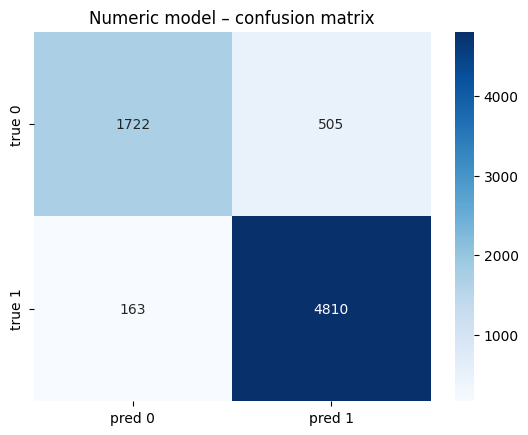

In [53]:
# Title: Confusion matrix heatmap – Numeric
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
pred = (numeric_model.predict_proba(Xn_test)[:,1] >= 0.5).astype(int)
cm = confusion_matrix(yn_test, pred, labels=[0,1])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['pred 0','pred 1'], yticklabels=['true 0','true 1'])
plt.title("Numeric model – confusion matrix"); plt.show()


### Top ten numeric features (permutation importance)

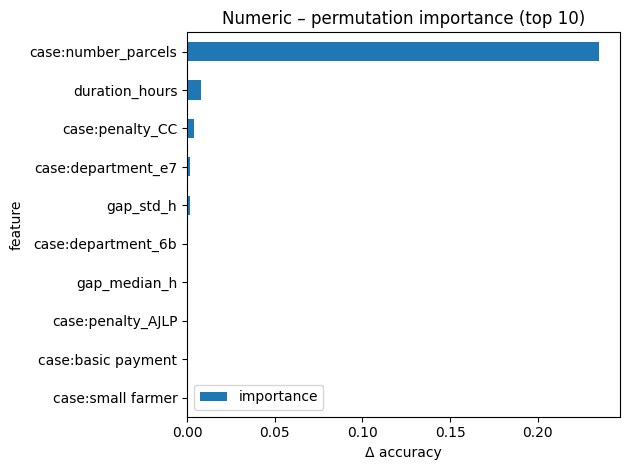

In [54]:
# Title: Numeric permutation importance – bar
imp10 = imp.head(10).iloc[::-1]
imp10.plot(kind='barh', x='feature', y='importance', title='Numeric – permutation importance (top 10)')
plt.xlabel('Δ accuracy'); plt.tight_layout(); plt.show()


### Figure 5.7 – Text model ROC curve

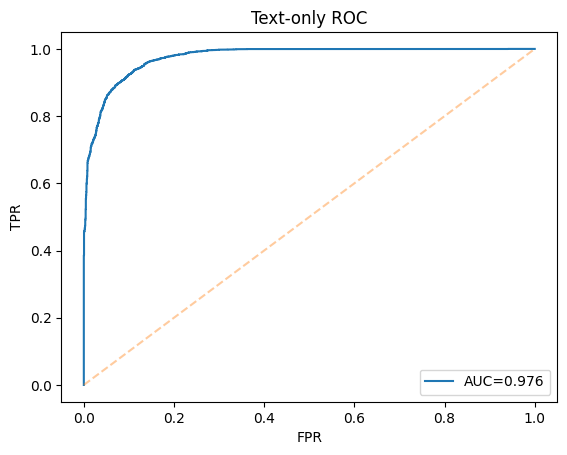

In [55]:
# Title: ROC – Text-only
from sklearn.metrics import roc_curve, auc
proba_txt = text_model.predict_proba(Xt_test)[:,1]
fpr_t, tpr_t, _ = roc_curve(yt_test, proba_txt)
plt.figure(); plt.plot(fpr_t, tpr_t, label=f"AUC={auc(fpr_t,tpr_t):.3f}")
plt.plot([0,1],[0,1],'--',alpha=0.4); plt.legend(); plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('Text-only ROC'); plt.show()


### Table 5.3 – Comparative performance summary (Acc/F1/AUC)

In [56]:
# Title: Comparison table – Acc / F1(w,m) / AUC
import pandas as pd
def metrics_row(name, model, Xte, yte):
    import numpy as np
    from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
    p = model.predict_proba(Xte)[:,1]; pred=(p>=0.5).astype(int)
    return {'model':name,
            'accuracy':accuracy_score(yte,pred),
            'f1_weighted':f1_score(yte,pred,average='weighted'),
            'f1_macro':f1_score(yte,pred,average='macro'),
            'roc_auc':roc_auc_score(yte,p)}
cmp = pd.DataFrame([
    metrics_row('Numeric',  numeric_model,  Xn_test, yn_test),
    metrics_row('Text',     text_model,     Xt_test, yt_test),
    metrics_row('Combined', combined_model, Xc_test, yc_test),
]).round(4)
display(cmp)


model  accuracy  f1_weighted  f1_macro  roc_auc
0   Numeric    0.9072       0.9049    0.8863   0.9549
1      Text    0.9265       0.9249    0.9105   0.9757
2  Combined    0.9210       0.9195    0.9041   0.9676

### Figure 6.1 – Structural vs. semantic inefficiency (conceptual)

In [57]:
# Title: Structural vs semantic indicators by class
struct = num_tbl.groupby('target_success')['duration_hours'].mean().rename({0:'failure',1:'success'})
print("Mean duration (h):"); display(struct.to_frame())

# crude semantic indicator: share of cases whose text_doc contains 'manual' or 'objection'
contains_kw = text_tbl.assign(manual=text_tbl['text_doc'].str.contains(r'\bmanual\b',case=False),
                              objection=text_tbl['text_doc'].str.contains(r'\bobjection\b',case=False))
sem = contains_kw.groupby('target_success')[['manual','objection']].mean().rename(index={0:'failure',1:'success'})
print("Share of cases with token present:"); display(sem.round(3))


Mean duration (h):


duration_hours
target_success                
failure            8131.971655
success            8636.816519

Share of cases with token present:


manual  objection
target_success                   
failure          0.120      0.056
success          0.062      0.009

### Additional stats

In [58]:
# Title: Quick summary statistics by case outcome and note category

import pandas as pd, numpy as np

# ---- base per-case table (if not already) ----
per_case_base = (df_cleaned
    .groupby(CASE_COL)
    .agg(first_time=(TIME_COL,'min'),
         last_time =(TIME_COL,'max'),
         n_events  =(ACT_COL,'size'))
    .assign(duration_hours=lambda d: (d['last_time'] - d['first_time']).dt.total_seconds()/3600))

tmp = df_cleaned.sort_values([CASE_COL, TIME_COL]).copy()
tmp['next_time'] = tmp.groupby(CASE_COL)[TIME_COL].shift(-1)
gaps = (tmp['next_time'] - tmp[TIME_COL]).dt.total_seconds()/3600
gap_stats = gaps.groupby(tmp[CASE_COL]).agg(gap_mean_h='mean')

per_case = (per_case_base.join(gap_stats)
            .merge(df_cleaned.groupby(CASE_COL)['success'].all()
                   .rename('target_success'), on=CASE_COL, how='left'))

# ---- attach simple "note type" indicator ----
note_col = 'note_cleaned' if 'note_cleaned' in df_cleaned.columns else 'note'
df_cleaned[note_col] = df_cleaned[note_col].astype(str).str.lower().str.strip()
note_type = (df_cleaned
    .groupby(CASE_COL)[note_col]
    .apply(lambda s: 'automatic' if s.str.contains('automatic').any() else 'manual_or_other'))
per_case = per_case.join(note_type.rename('note_type'), on=CASE_COL)

# ---- overall averages ----
print("Overall averages:")
display(per_case[['n_events','duration_hours','gap_mean_h']].mean().to_frame('mean').T.round(2))

# ---- by success/failure ----
print("\nBy success (1) / failure (0):")
display(per_case.groupby('target_success')[['n_events','duration_hours','gap_mean_h']]
        .mean().round(2).rename(index={0:'failure',1:'success'}))

# ---- by note type ----
print("\nBy note type (automatic vs manual/other):")
display(per_case.groupby('note_type')[['n_events','duration_hours','gap_mean_h']]
        .mean().round(2))


Overall averages:


n_events  duration_hours  gap_mean_h
mean     57.15         8480.64      159.52


By success (1) / failure (0):


n_events  duration_hours  gap_mean_h
target_success                                      
failure            66.67         8131.97      132.46
success            52.89         8636.82      171.64


By note type (automatic vs manual/other):


n_events  duration_hours  gap_mean_h
note_type                                      
automatic     57.15         8480.64      159.52

In [59]:
# Title: Train/Test split summary (sizes + class balance)
import pandas as pd
def split_summary(name, y_train, y_test):
    s = pd.DataFrame({
        'set': ['train','test'],
        'n_samples': [len(y_train), len(y_test)],
        'n_pos': [int((y_train==1).sum()), int((y_test==1).sum())],
        'n_neg': [int((y_train==0).sum()), int((y_test==0).sum())]
    })
    s['pos_rate'] = (s['n_pos']/s['n_samples']).round(3)
    print(f"{name}"); display(s)

split_summary("Numeric split", yn_train, yn_test)
split_summary("Text split",    yt_train, yt_test)
split_summary("Combined split",yc_train, yc_test)


Numeric split


set  n_samples  n_pos  n_neg  pos_rate
0  train      28800  19890   8910     0.691
1   test       7200   4973   2227     0.691

Text split


set  n_samples  n_pos  n_neg  pos_rate
0  train      28800  19890   8910     0.691
1   test       7200   4973   2227     0.691

Combined split


set  n_samples  n_pos  n_neg  pos_rate
0  train      28800  19890   8910     0.691
1   test       7200   4973   2227     0.691